In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [2]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
color = sns.color_palette("Paired")
%matplotlib inline

#### Data Pre-processing

In [3]:
data = pd.read_csv('bank-full.csv', sep =';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
 # proportion of unknown values in each column
unknown_proportion = np.mean(data =='unknown', axis = 0)
index = unknown_proportion>0
unknown_proportion = unknown_proportion[index]
unknown_proportion

job          0.006370
education    0.041074
contact      0.287983
poutcome     0.817478
dtype: float64

In [5]:
# Impute varibles with 'Unknown' values with most fequent values
imputer = SimpleImputer(missing_values = 'unknown' ,strategy='most_frequent')
data[unknown_proportion.index] = imputer.fit_transform(data[unknown_proportion.index])

In [6]:
# one hot encode: job, martial, poutcome
df = pd.get_dummies(data, columns = ['job','marital','poutcome','contact'], drop_first= True)

# label encode month, education
replace_month = {"jan":1, "feb":2, "mar":3, "apr":4,
                  "may":5,"jun":6, "jul":7, "aug":8,
                  "sep":9,"oct":10, "nov":11,"dec":12}

replace_education = {"unknown": 0,"primary":1, "secondary":2, "tertiary":3}


df = df.replace({'month': replace_month,
                'education': replace_education})

# categorize days into week of month
#df['week'] = pd.cut(df['day'], [0,7,14,21,28,31] , labels =[1,2,3,4,5])
#df.drop('day', axis =1, inplace = True)

# replace "yes" and "no" with "1" and "0"
df = df.replace(['yes'], 1)
df = df.replace(['no'], 0)

df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,contact_telephone
0,58,3,0,2143,1,0,5,5,261,1,...,0,0,0,0,0,1,0,0,0,0
1,44,2,0,29,1,0,5,5,151,1,...,0,0,0,1,0,0,1,0,0,0
2,33,2,0,2,1,1,5,5,76,1,...,0,0,0,0,0,1,0,0,0,0
3,47,2,0,1506,1,0,5,5,92,1,...,0,0,0,0,0,1,0,0,0,0
4,33,2,0,1,0,0,5,5,198,1,...,0,0,0,0,0,0,1,0,0,0


#### Lasso Feature Selection

In [7]:
# Define independent and dependent variables
X = df.drop(['y'], axis = 1)
y = df['y']

In [8]:
alphas = np.arange(0.001, 1, 0.1)

param_grid = {'alpha': alphas} 
grid = GridSearchCV(Lasso(), param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)

best_alpha = grid.best_params_['alpha'] # best alpha value
best_alpha

0.001

In [9]:
lasso = Lasso(alpha = grid.best_params_['alpha'], random_state=5)
lasso.fit(X, y)
lasso_coef = pd.DataFrame({'feature': X.columns, 'coefficient': lasso.coef_})


print('******* Features with Coefficient = 0 ******* \n')
print(lasso_coef[lasso_coef['coefficient']==0].reset_index(drop = True))

print('\n\n ******* Selected Features ******* \n')
print(lasso_coef[lasso_coef['coefficient']!=0].reset_index(drop = True))

******* Features with Coefficient = 0 ******* 

             feature  coefficient
0            default         -0.0
1              month          0.0
2   job_entrepreneur         -0.0
3      job_housemaid         -0.0
4     job_management          0.0
5  job_self-employed         -0.0
6       job_services         -0.0
7     job_technician         -0.0
8     job_unemployed          0.0
9  contact_telephone          0.0


 ******* Selected Features ******* 

             feature  coefficient
0                age     0.000282
1          education     0.016386
2            balance     0.000002
3            housing    -0.067391
4               loan    -0.026018
5                day    -0.000121
6           duration     0.000476
7           campaign    -0.002099
8              pdays     0.000155
9           previous     0.002868
10   job_blue-collar    -0.010607
11       job_retired     0.038534
12       job_student     0.062738
13   marital_married    -0.008615
14    marital_single     0.01

In [10]:
selected_features = lasso_coef.loc[lasso_coef['coefficient']!=0, 'feature']
X_lasso = X[selected_features]

#### Check correlation

C:\Users\tammy\AppData\Local\Temp\ipykernel_13908\3342443875.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


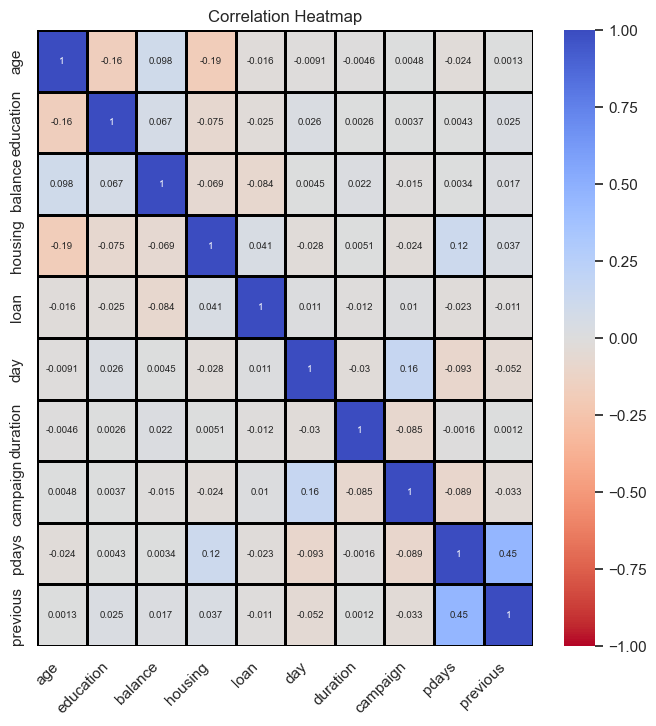

In [11]:
import seaborn as sns
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(X_lasso.select_dtypes(include=['int32','int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [14]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_df = calc_vif(X_lasso.select_dtypes(include=['int32','int64','float64']))
vif_df

,variables,VIF,tolerance,meanVIF
0,age,7.717605,0.129574,3.065903
1,education,7.354460,0.135972,3.065903
2,balance,1.231135,0.812259,3.065903
3,housing,2.114518,0.472921,3.065903
4,loan,1.195186,0.836690,3.065903
5,day,4.400077,0.227269,3.065903
6,duration,1.961343,0.509855,3.065903
7,campaign,1.845396,0.541889,3.065903
8,pdays,1.496244,0.668340,3.065903
9,previous,1.343073,0.744561,3.065903


#### Imbalanced Data


In [15]:
# proportion of 'yes' and 'no' is imbalanced
df['y'].value_counts(normalize = True)

0    0.883015
1    0.116985
Name: y, dtype: float64

In [16]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X_lasso,y,test_size=0.2,random_state=100)

In [17]:
# Feature Scaling
scale_features = ['age', 'education', 'balance', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()
X_train_scaled = X_train[scale_features]
X_train_scaled= scaler.fit_transform(X_train_scaled)

X_test_scaled = X_test[scale_features]
X_test_scaled = scaler.transform(X_test_scaled)

# Replace original continuous features with scaled ones in X

X_train[scale_features] = X_train_scaled
X_test[scale_features] = X_test_scaled

In [18]:
# Define Oversampling and Undersampling methods
over_sample = SMOTE(random_state= 100)
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train.ravel())


under_sample = TomekLinks(sampling_strategy ='majority')
X_train_under, y_train_under = under_sample.fit_resample(X_train, y_train.ravel())

print("************** Original **************")
print("Before OverSampling, proportion of label '1': {:.2%}".format(np.mean(y_train==1)))
print("Before OverSampling, count of label '1': {:}".format(np.sum(y_train==1)))
print("Before OverSampling, proportion of label '0': {:.2%}".format(np.mean(y_train==0)))
print("Before OverSampling, count of label '0': {:}\n".format(np.sum(y_train==0)))

print("************** Over-sampling **************")
print("After OverSampling, proportion of label '1': {:.2%}".format(np.mean(y_train_over==1)))
print("After OverSampling, count of label '1': {:}".format(np.sum(y_train_over==1)))
print("After OverSampling, proportion of label '0': {:.2%}".format(np.mean(y_train_over==0)))
print("After OverSampling, count of label '0': {:}\n".format(np.sum(y_train_over==0)))


print("************** Under-sampling **************")
print("After UnderSampling, proportion of label '1': {:.2%}".format(np.mean(y_train_under==1)))
print("After UnderSampling, count of label '1': {:}".format(np.sum(y_train_under==1)))
print("After UnderSampling, proportion of label '0': {:.2%}".format(np.mean(y_train_under==0)))
print("After UnderSampling, count of label '0': {:}\n".format(np.sum(y_train_under==0)))

************** Original **************
Before OverSampling, proportion of label '1': 11.75%
Before OverSampling, count of label '1': 4250
Before OverSampling, proportion of label '0': 88.25%
Before OverSampling, count of label '0': 31918

************** Over-sampling **************
After OverSampling, proportion of label '1': 50.00%
After OverSampling, count of label '1': 31918
After OverSampling, proportion of label '0': 50.00%
After OverSampling, count of label '0': 31918

************** Under-sampling **************
After UnderSampling, proportion of label '1': 12.15%
After UnderSampling, count of label '1': 4250
After UnderSampling, proportion of label '0': 87.85%
After UnderSampling, count of label '0': 30741



In [19]:
pd.DataFrame(y_train_over).value_counts(normalize = True)*100

0    50.0
1    50.0
dtype: float64

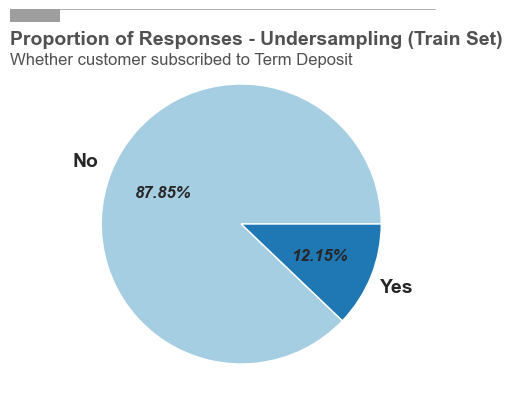

In [20]:
fig, ax = plt.subplots(figsize = (5,5))


patches, texts, autotexts = plt.pie(pd.DataFrame(y_train_under).value_counts(normalize = True)*100,
                                    labels = ('No', 'Yes'),
                                    colors = color, autopct='%.2f%%',
                                   labeldistance =1.2)
for text in texts:
    text.set_fontweight('bold')
    text.set_horizontalalignment('center')
    text.set_fontsize(14)
    
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')
    autotext.set_fontsize(12)
   

# Add in grey line and rectangle on top
ax.plot([0.05, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.91, s="Proportion of Responses - Undersampling (Train Set)", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.05, y=.87, s="Whether customer subscribed to Term Deposit", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)


plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.9, wspace=None, hspace=None)

plt.show()

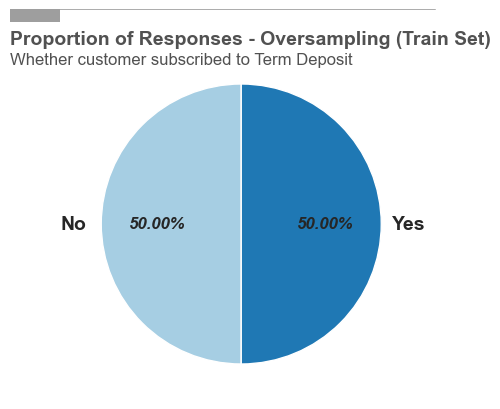

In [21]:
fig, ax = plt.subplots(figsize = (5,5))


patches, texts, autotexts = plt.pie(pd.DataFrame(y_train_over).value_counts(normalize = True)*100,
                                    labels = ('No', 'Yes'),
                                    colors = color, autopct='%.2f%%',
                                   labeldistance =1.2, startangle=90)
for text in texts:
    text.set_fontweight('bold')
    text.set_horizontalalignment('center')
    text.set_fontsize(14)
    
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')
    autotext.set_fontsize(12)
   

# Add in grey line and rectangle on top
ax.plot([0.05, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.91, s="Proportion of Responses - Oversampling (Train Set)", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.05, y=.87, s="Whether customer subscribed to Term Deposit", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)


plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.9, wspace=None, hspace=None)

plt.show()

### Model Building

#### Performance Measure

In [22]:
def performance_measure (model, evaluate_on):
    
    if evaluate_on == 'over_sample':
        X,y = X_train_over, y_train_over
    elif evaluate_on == 'under_sample':
        X,y = X_train_under, y_train_under
    else:
        print('Error: evaluate_on must be either "over_sample" or "under_sample"')
        X, y = (None, None)
        
    model.fit(X,y)
    
    # predict Probability
    model_prob = model.predict_proba(X_test)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y_test))]
    
    # predict Label
    pred_label = model.predict(X_test) #default threshold =0.5
    cm = confusion_matrix(y_test, pred_label, labels=[1, 0], sample_weight=None)
    
    # Get scores and Ratios
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Negatives                                                                                         
    FP = cm[1][0] # False Positives                                                                                        
    TN = cm[1][1] # True Negatives                                                                                          
        
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    precision = TP/(TP+FP)
    
    f1_score = metrics.f1_score(y_test, pred_label)
    
    # Get AUC Scores
    model_auc = roc_auc_score(y_test,model_prob)
    
    # Calculate ROC Curve
    model_fpr,model_tpr,_ =roc_curve(y_test,model_prob)
    
    # ROC score from cross validation
    cv_roc_score = np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc' ))
    
    # F1 score from cross validation
    cv_f1_score = np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='f1' ))

    
   
    print('f1_score = {:.5}'.format(f1_score))
    print('mean f1_score = {:.5}'.format(cv_f1_score))
    print('roc_auc_score = {:.5}'.format(model_auc))
    print('mean roc_auc_score = {:.5}'.format(cv_roc_score))
    
    print('Accuracy = {:.5}'.format(Accuracy))
    print('Precision = {:.5}'.format(precision))
   
    print('TPR = {:.5}'.format(TPR))
    print('FNR = {:.5}'.format(FNR))
    print('TNR = {:.5}'.format(TNR))
    print('FPR = {:.5}'.format(FPR))
    
        
    return model_auc, cv_roc_score, f1_score, cv_f1_score,  model_fpr, model_tpr

#### Logistic Regression (all features)

In [23]:
lr_over = LogisticRegression(solver = 'liblinear', max_iter= 1000, random_state =100)
lr_over_auc, lr_over_cv_auc, lr_over_f1, lr_over_cv_f1, lr_over_fpr, lr_over_tpr = performance_measure(lr_over, 'over_sample')

f1_score = 0.49299
mean f1_score = 0.39023
roc_auc_score = 0.87115
mean roc_auc_score = 0.87301
Accuracy = 0.82008
Precision = 0.36452
TPR = 0.76131
FNR = 0.23869
TNR = 0.82771
FPR = 0.17229


In [18]:
lr_under = LogisticRegression(solver = 'liblinear', max_iter= 1000, random_state =100)
lr_under_auc, lr_under_cv_auc, lr_under_f1, lr_under_cv_f1, lr_under_fpr, lr_under_tpr = performance_measure(lr_under, 'under_sample')

f1_score = 0.44088
mean f1_score = 0.39023
roc_auc_score = 0.87467
mean roc_auc_score = 0.87301
Accuracy = 0.89594
Precision = 0.57609
TPR = 0.35707
FNR = 0.64293
TNR = 0.96589
FPR = 0.034108


#### Random Forest

In [19]:
rf_over = RandomForestClassifier(random_state =100)
rf_over_auc, rf_over_cv_auc, rf_over_f1, rf_over_cv_f1, rf_over_fpr, rf_over_tpr = performance_measure(rf_over, 'over_sample')

f1_score = 0.53011
mean f1_score = 0.41772
roc_auc_score = 0.88131
mean roc_auc_score = 0.87541
Accuracy = 0.87747
Precision = 0.47384
TPR = 0.60154
FNR = 0.39846
TNR = 0.91329
FPR = 0.086707


In [20]:
rf_under = RandomForestClassifier(random_state =100)
rf_under_auc, rf_under_cv_auc,rf_under_f1, rf_under_cv_f1, rf_under_fpr, rf_under_tpr = performance_measure(rf_under, 'under_sample')

f1_score = 0.50081
mean f1_score = 0.41772
roc_auc_score = 0.88338
mean roc_auc_score = 0.87541
Accuracy = 0.89771
Precision = 0.57002
TPR = 0.44658
FNR = 0.55342
TNR = 0.95627
FPR = 0.043728


#### XGBoost

In [21]:
xgb_over = XGBClassifier(random_state =100)
xgb_over_auc, xgb_over_cv_auc, xgb_over_f1, xgb_over_cv_f1, xgb_over_fpr, xgb_over_tpr = performance_measure(xgb_over, 'over_sample')

f1_score = 0.51753
mean f1_score = 0.42186
roc_auc_score = 0.89265
mean roc_auc_score = 0.8692
Accuracy = 0.89649
Precision = 0.55716
TPR = 0.48316
FNR = 0.51684
TNR = 0.95015
FPR = 0.04985


In [22]:
xgb_under = XGBClassifier(random_state =100)
xgb_under_auc, xgb_under_cv_auc, xgb_under_f1, xgb_under_cv_f1, xgb_under_fpr, xgb_under_tpr = performance_measure(xgb_under, 'under_sample')

f1_score = 0.50605
mean f1_score = 0.42186
roc_auc_score = 0.89107
mean roc_auc_score = 0.8692
Accuracy = 0.89616
Precision = 0.558
TPR = 0.46295
FNR = 0.53705
TNR = 0.9524
FPR = 0.047601


#### Decision Tree Classifier

In [23]:
dt_over = DecisionTreeClassifier(random_state =100)
dt_over_auc, dt_over_cv_auc, dt_over_f1, dt_over_cv_f1, dt_over_fpr, dt_over_tpr = performance_measure(dt_over, 'over_sample')

f1_score = 0.4092
mean f1_score = 0.38041
roc_auc_score = 0.68791
mean roc_auc_score = 0.65387
Accuracy = 0.83523
Precision = 0.34794
TPR = 0.49663
FNR = 0.50337
TNR = 0.87919
FPR = 0.12081


In [24]:
dt_under = DecisionTreeClassifier(random_state =100)
dt_under_auc, dt_under_cv_auc, dt_under_f1, dt_under_cv_f1, dt_under_fpr, dt_under_tpr = performance_measure(dt_under, 'under_sample')

f1_score = 0.42261
mean f1_score = 0.38041
roc_auc_score = 0.68547
mean roc_auc_score = 0.65387
Accuracy = 0.85315
Precision = 0.38541
TPR = 0.46776
FNR = 0.53224
TNR = 0.90317
FPR = 0.096827


#### Performance Comparison

In [25]:
auc_scores_over = [lr_over_auc, rf_over_auc, xgb_over_auc, dt_over_auc]
auc_scores_under = [lr_under_auc, rf_under_auc, xgb_under_auc, dt_under_auc]

auc_over = 0
auc_under =0

for over, under in zip(auc_scores_over, auc_scores_under):
    if over < under:
        auc_under += 1
    else:
        auc_over += 1
            
print('AUC Score:')
print('Number of models where oversampling > undersampling = ', auc_over)
print('Number of models where undersampling > oversampling = ', auc_under)

AUC Score:
Number of models where oversampling > undersampling =  2
Number of models where undersampling > oversampling =  2


In [26]:
cv_auc_scores_over = [lr_over_cv_auc, rf_over_cv_auc, xgb_over_cv_auc, dt_over_cv_auc]
cv_auc_scores_under = [lr_under_cv_auc, rf_under_cv_auc, xgb_under_cv_auc, dt_under_cv_auc]

cv_auc_over = 0
cv_auc_under = 0

for over, under in zip(cv_auc_scores_over, cv_auc_scores_under):
    if over < under:
        cv_auc_under += 1
    else:
        cv_auc_over += 1

print('Cross validation: AUC Score:')
print('Number of models where oversampling > undersampling = ', auc_over)
print('Number of models where undersampling > oversampling = ', auc_under)

Cross validation: AUC Score:
Number of models where oversampling > undersampling =  2
Number of models where undersampling > oversampling =  2


In [27]:
f1_scores_over = [lr_over_f1, rf_over_f1, xgb_over_f1, dt_over_f1]
f1_scores_under = [lr_under_f1, rf_under_f1, xgb_under_f1, dt_under_f1]

f1_over = 0
f1_under = 0

for over, under in zip(f1_scores_over, f1_scores_under):
    if over < under:
        f1_under += 1
    else:
        f1_over += 1

print('F1 Score:')
print('Number of models where oversampling > undersampling = ', f1_over)
print('Number of models where undersampling > oversampling = ', f1_under)

F1 Score:
Number of models where oversampling > undersampling =  3
Number of models where undersampling > oversampling =  1


In [28]:
cv_f1_scores_over = [lr_over_cv_f1, rf_over_cv_f1, xgb_over_cv_f1, dt_over_cv_f1]
cv_f1_scores_under = [lr_under_cv_f1, rf_under_cv_f1, xgb_under_cv_f1, dt_under_cv_f1]

cv_f1_over = 0
cv_f1_under = 0

for over, under in zip(cv_f1_scores_over, cv_f1_scores_under):
    if over < under:
        cv_f1_under += 1
    else:
        cv_f1_over += 1

print('Cross validation: F1 Score:')
print('Number of models where oversampling > undersampling = ', f1_over)
print('Number of models where undersampling > oversampling = ', f1_under)

Cross validation: F1 Score:
Number of models where oversampling > undersampling =  3
Number of models where undersampling > oversampling =  1


#### Cross Validation and Hyperparameter tuning (use oversampling method)

#### Performance Measure

In [24]:
def performance_measure_cv (model, evaluate_on = 'over_sample'):
    
    if evaluate_on == 'over_sample':
        X,y = X_train_over, y_train_over
    elif evaluate_on == 'under_sample':
        X,y = X_train_under, y_train_under
    else:
        print('Error: evaluate_on must be either "over_sample" or "under_sample"')
        X, y = (None, None)
        
    model.fit(X,y)
    
    # predict Probability
    model_prob = model.predict_proba(X_test)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y_test))]
    
    # predict Label
    pred_label = model.predict(X_test) #default threshold =0.5
    cm = confusion_matrix(y_test, pred_label, labels=[1, 0], sample_weight=None)
    
    # Get scores and Ratios
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Negatives                                                                                         
    FP = cm[1][0] # False Positives                                                                                        
    TN = cm[1][1] # True Negatives                                                                                          
        
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    precision = TP/(TP+FP)
    
    # Get F1 Scores
    f1_score = metrics.f1_score(y_test, pred_label)
    
    # Calculate precision-recall curve
    model_precision, model_recall,_ = precision_recall_curve(y_test,model_prob)
    
    # Get AUC Scores
    model_auc = roc_auc_score(y_test,model_prob)
    
    # Calculate ROC Curve
    model_fpr,model_tpr,_ =roc_curve(y_test,model_prob)

    
   
    print('f1_score = {:.5}'.format(f1_score))
    print('roc_auc_score = {:.5}'.format(model_auc))
    
    print('Accuracy = {:.5}'.format(Accuracy))
    print('Precision = {:.5}'.format(precision))
   
    print('TPR = {:.5}'.format(TPR))
    print('FNR = {:.5}'.format(FNR))
    print('TNR = {:.5}'.format(TNR))
    print('FPR = {:.5}'.format(FPR))
    
         
    return model_auc, f1_score, model_fpr, model_tpr, model_precision, model_recall

##### Logistic Regression

In [25]:
alphas = np.array([100, 10, 1.0, 0.1, 0.01])

param_grid = {'C': 1/alphas} 
grid = GridSearchCV(lr_over, param_grid=param_grid, cv=5, scoring='f1')
grid.fit(X_train_over, y_train_over)
print(grid.best_params_)

{'C': 0.01}


In [26]:
lr_cv = LogisticRegression(**grid.best_params_, solver = 'liblinear', max_iter= 1000, random_state =100)
lr_cv_auc, lr_cv_f1, lr_cv_fpr, lr_cv_tpr, lr_cv_precision, lr_cv_recall = performance_measure_cv(lr_cv)

f1_score = 0.4916
roc_auc_score = 0.87152
Accuracy = 0.81931
Precision = 0.36322
TPR = 0.76035
FNR = 0.23965
TNR = 0.82696
FPR = 0.17304


In [46]:
lr_importance = pd.DataFrame(list(zip(X_train_over.columns, lr_cv.coef_.ravel())), columns =['Features', 'Coeff'])
lr_importance['Coeff_ABS'] = np.abs(lr_importance['Coeff'])
lr_importance['odds'] = np.exp(lr_cv.coef_[0])
lr_importance = lr_importance.sort_values('Coeff_ABS', ascending=False).reset_index(drop= True)
lr_importance['color'] = lr_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_importance['odds_color'] = lr_importance['odds'].apply(lambda x: '#66ff8c' if x>1 else '#ff8c66')
lr_importance

,Features,Coeff,Coeff_ABS,odds,color,odds_color
0,poutcome_success,1.785057,1.785057,5.959918,#66ff8c,#66ff8c
1,duration,1.422060,1.422060,4.145650,#66ff8c,#66ff8c
2,housing,-1.405518,1.405518,0.245240,#ff8c66,#ff8c66
3,job_blue-collar,-0.583353,0.583353,0.558024,#ff8c66,#ff8c66
4,campaign,-0.530979,0.530979,0.588029,#ff8c66,#ff8c66
5,poutcome_other,-0.525828,0.525828,0.591065,#ff8c66,#ff8c66
6,job_student,0.372349,0.372349,1.451139,#66ff8c,#66ff8c
7,job_retired,0.340323,0.340323,1.405401,#66ff8c,#66ff8c
8,marital_married,-0.337456,0.337456,0.713583,#ff8c66,#ff8c66
9,loan,-0.285002,0.285002,0.752013,#ff8c66,#ff8c66


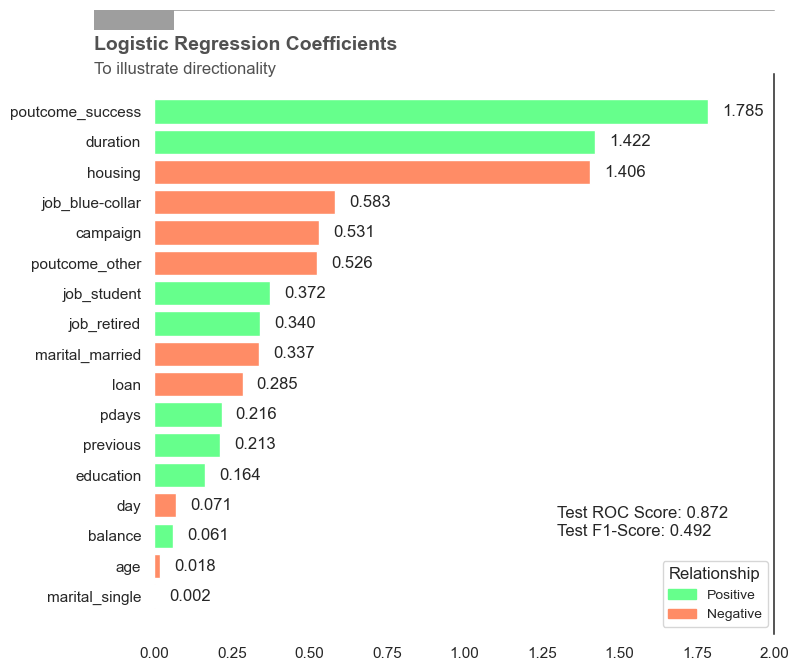

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
graph = ax.barh(lr_importance['Features'], lr_importance['Coeff_ABS'],
                color=lr_importance['color'])


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.93, s="Logistic Regression Coefficients", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.05, y=.9, s="To illustrate directionality", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10', facecolor = 'white')
plt.annotate(('Test ROC Score: ' + str(round(lr_cv_auc,3)) + '\nTest F1-Score: ' + str(round(lr_cv_f1,3))),
             xy=(1.3,14), fontsize = 12)


#plt.title('Linear Regression Coefficients', size = 15)
#plt.ylabel('Features', size = 12, labelpad=15)
#plt.xlabel('Coefficient', size = 12, labelpad=15)
ax.bar_label(graph, fmt='%.3f', padding =10)
ax.set_xlim(right=2) 
ax.invert_yaxis()

plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.9, wspace=None, hspace=None)

plt.show()

#### Random Forest

In [34]:
param_grid = {'n_estimators':np.arange(10,200,20),
             #'max_features': ['auto', 'sqrt'],
             'min_samples_split':np.arange(2,10,2),
              'min_samples_leaf':np.arange(1,10,2)} 

grid = GridSearchCV(rf_over, param_grid=param_grid, cv=5, scoring='f1', verbose = 10)
grid.fit(X_train_over, y_train_over)
print(grid.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5; 1/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=10..
[CV 1/5; 1/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.848 total time=   0.7s
[CV 2/5; 1/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=10..
[CV 2/5; 1/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.938 total time=   0.7s
[CV 3/5; 1/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=10..
[CV 3/5; 1/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.934 total time=   0.6s
[CV 4/5; 1/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=10..
[CV 4/5; 1/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.934 total time=   0.6s
[CV 5/5; 1/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=10..
[CV 5/5; 1/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.943 

[CV 4/5; 9/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=170;, score=0.941 total time=  12.2s
[CV 5/5; 9/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=170.
[CV 5/5; 9/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=170;, score=0.945 total time=  12.2s
[CV 1/5; 10/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 1/5; 10/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=190;, score=0.878 total time=  12.9s
[CV 2/5; 10/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 2/5; 10/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=190;, score=0.945 total time=  14.1s
[CV 3/5; 10/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 3/5; 10/200] END min_samples_leaf=1, min_samples_split=2, n_estimators=190;, score=0.942 total time=  14.4s
[CV 4/5; 10/200] START min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 4/5; 10/200] END min_samples_leaf

[CV 2/5; 18/200] END min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.943 total time=  10.2s
[CV 3/5; 18/200] START min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 3/5; 18/200] END min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.937 total time=  10.3s
[CV 4/5; 18/200] START min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 4/5; 18/200] END min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.939 total time=  10.1s
[CV 5/5; 18/200] START min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/5; 18/200] END min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=0.943 total time=  10.3s
[CV 1/5; 19/200] START min_samples_leaf=1, min_samples_split=4, n_estimators=170
[CV 1/5; 19/200] END min_samples_leaf=1, min_samples_split=4, n_estimators=170;, score=0.874 total time=  11.5s
[CV 2/5; 19/200] START min_samples_leaf=1, min_samples_split=4, n_estimators=170
[CV 2/5; 19/200] END min_samples_le

[CV 5/5; 26/200] END min_samples_leaf=1, min_samples_split=6, n_estimators=110;, score=0.939 total time=   7.3s
[CV 1/5; 27/200] START min_samples_leaf=1, min_samples_split=6, n_estimators=130
[CV 1/5; 27/200] END min_samples_leaf=1, min_samples_split=6, n_estimators=130;, score=0.869 total time=   8.8s
[CV 2/5; 27/200] START min_samples_leaf=1, min_samples_split=6, n_estimators=130
[CV 2/5; 27/200] END min_samples_leaf=1, min_samples_split=6, n_estimators=130;, score=0.939 total time=   8.7s
[CV 3/5; 27/200] START min_samples_leaf=1, min_samples_split=6, n_estimators=130
[CV 3/5; 27/200] END min_samples_leaf=1, min_samples_split=6, n_estimators=130;, score=0.936 total time=   8.7s
[CV 4/5; 27/200] START min_samples_leaf=1, min_samples_split=6, n_estimators=130
[CV 4/5; 27/200] END min_samples_leaf=1, min_samples_split=6, n_estimators=130;, score=0.935 total time=   8.7s
[CV 5/5; 27/200] START min_samples_leaf=1, min_samples_split=6, n_estimators=130
[CV 5/5; 27/200] END min_samples_le

[CV 3/5; 35/200] END min_samples_leaf=1, min_samples_split=8, n_estimators=90;, score=0.933 total time=   6.1s
[CV 4/5; 35/200] START min_samples_leaf=1, min_samples_split=8, n_estimators=90.
[CV 4/5; 35/200] END min_samples_leaf=1, min_samples_split=8, n_estimators=90;, score=0.933 total time=   6.1s
[CV 5/5; 35/200] START min_samples_leaf=1, min_samples_split=8, n_estimators=90.
[CV 5/5; 35/200] END min_samples_leaf=1, min_samples_split=8, n_estimators=90;, score=0.938 total time=   6.0s
[CV 1/5; 36/200] START min_samples_leaf=1, min_samples_split=8, n_estimators=110
[CV 1/5; 36/200] END min_samples_leaf=1, min_samples_split=8, n_estimators=110;, score=0.866 total time=   7.3s
[CV 2/5; 36/200] START min_samples_leaf=1, min_samples_split=8, n_estimators=110
[CV 2/5; 36/200] END min_samples_leaf=1, min_samples_split=8, n_estimators=110;, score=0.938 total time=   7.3s
[CV 3/5; 36/200] START min_samples_leaf=1, min_samples_split=8, n_estimators=110
[CV 3/5; 36/200] END min_samples_leaf=

[CV 1/5; 44/200] END min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=0.866 total time=   4.5s
[CV 2/5; 44/200] START min_samples_leaf=3, min_samples_split=2, n_estimators=70.
[CV 2/5; 44/200] END min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=0.929 total time=   4.4s
[CV 3/5; 44/200] START min_samples_leaf=3, min_samples_split=2, n_estimators=70.
[CV 3/5; 44/200] END min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=0.924 total time=   4.5s
[CV 4/5; 44/200] START min_samples_leaf=3, min_samples_split=2, n_estimators=70.
[CV 4/5; 44/200] END min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=0.926 total time=   4.4s
[CV 5/5; 44/200] START min_samples_leaf=3, min_samples_split=2, n_estimators=70.
[CV 5/5; 44/200] END min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=0.930 total time=   4.5s
[CV 1/5; 45/200] START min_samples_leaf=3, min_samples_split=2, n_estimators=90.
[CV 1/5; 45/200] END min_samples_leaf=3,

[CV 4/5; 52/200] END min_samples_leaf=3, min_samples_split=4, n_estimators=30;, score=0.925 total time=   1.9s
[CV 5/5; 52/200] START min_samples_leaf=3, min_samples_split=4, n_estimators=30.
[CV 5/5; 52/200] END min_samples_leaf=3, min_samples_split=4, n_estimators=30;, score=0.927 total time=   1.9s
[CV 1/5; 53/200] START min_samples_leaf=3, min_samples_split=4, n_estimators=50.
[CV 1/5; 53/200] END min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=0.866 total time=   3.1s
[CV 2/5; 53/200] START min_samples_leaf=3, min_samples_split=4, n_estimators=50.
[CV 2/5; 53/200] END min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=0.927 total time=   3.1s
[CV 3/5; 53/200] START min_samples_leaf=3, min_samples_split=4, n_estimators=50.
[CV 3/5; 53/200] END min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=0.925 total time=   3.5s
[CV 4/5; 53/200] START min_samples_leaf=3, min_samples_split=4, n_estimators=50.
[CV 4/5; 53/200] END min_samples_leaf=3,

[CV 2/5; 61/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=10;, score=0.922 total time=   0.5s
[CV 3/5; 61/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=10.
[CV 3/5; 61/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=10;, score=0.922 total time=   0.6s
[CV 4/5; 61/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=10.
[CV 4/5; 61/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=10;, score=0.919 total time=   0.5s
[CV 5/5; 61/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=10.
[CV 5/5; 61/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=10;, score=0.927 total time=   0.5s
[CV 1/5; 62/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=30.
[CV 1/5; 62/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=30;, score=0.864 total time=   1.8s
[CV 2/5; 62/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=30.
[CV 2/5; 62/200] END min_samples_leaf=3,

[CV 5/5; 69/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=170;, score=0.929 total time=  11.0s
[CV 1/5; 70/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=190
[CV 1/5; 70/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=190;, score=0.868 total time=  12.2s
[CV 2/5; 70/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=190
[CV 2/5; 70/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=190;, score=0.930 total time=  13.2s
[CV 3/5; 70/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=190
[CV 3/5; 70/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=190;, score=0.926 total time=  16.9s
[CV 4/5; 70/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=190
[CV 4/5; 70/200] END min_samples_leaf=3, min_samples_split=6, n_estimators=190;, score=0.926 total time=  15.1s
[CV 5/5; 70/200] START min_samples_leaf=3, min_samples_split=6, n_estimators=190
[CV 5/5; 70/200] END min_samples_le

[CV 3/5; 78/200] END min_samples_leaf=3, min_samples_split=8, n_estimators=150;, score=0.925 total time=  10.3s
[CV 4/5; 78/200] START min_samples_leaf=3, min_samples_split=8, n_estimators=150
[CV 4/5; 78/200] END min_samples_leaf=3, min_samples_split=8, n_estimators=150;, score=0.924 total time=  10.7s
[CV 5/5; 78/200] START min_samples_leaf=3, min_samples_split=8, n_estimators=150
[CV 5/5; 78/200] END min_samples_leaf=3, min_samples_split=8, n_estimators=150;, score=0.930 total time=  11.3s
[CV 1/5; 79/200] START min_samples_leaf=3, min_samples_split=8, n_estimators=170
[CV 1/5; 79/200] END min_samples_leaf=3, min_samples_split=8, n_estimators=170;, score=0.864 total time=  12.6s
[CV 2/5; 79/200] START min_samples_leaf=3, min_samples_split=8, n_estimators=170
[CV 2/5; 79/200] END min_samples_leaf=3, min_samples_split=8, n_estimators=170;, score=0.928 total time=  11.9s
[CV 3/5; 79/200] START min_samples_leaf=3, min_samples_split=8, n_estimators=170
[CV 3/5; 79/200] END min_samples_le

[CV 1/5; 87/200] END min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=0.860 total time=   8.4s
[CV 2/5; 87/200] START min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 2/5; 87/200] END min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=0.922 total time=   8.3s
[CV 3/5; 87/200] START min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 3/5; 87/200] END min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=0.917 total time=   8.4s
[CV 4/5; 87/200] START min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 4/5; 87/200] END min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=0.918 total time=   8.2s
[CV 5/5; 87/200] START min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 5/5; 87/200] END min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=0.921 total time=   8.4s
[CV 1/5; 88/200] START min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/5; 88/200] END min_samples_le

[CV 4/5; 95/200] END min_samples_leaf=5, min_samples_split=4, n_estimators=90;, score=0.917 total time=   5.7s
[CV 5/5; 95/200] START min_samples_leaf=5, min_samples_split=4, n_estimators=90.
[CV 5/5; 95/200] END min_samples_leaf=5, min_samples_split=4, n_estimators=90;, score=0.920 total time=   5.8s
[CV 1/5; 96/200] START min_samples_leaf=5, min_samples_split=4, n_estimators=110
[CV 1/5; 96/200] END min_samples_leaf=5, min_samples_split=4, n_estimators=110;, score=0.860 total time=   6.9s
[CV 2/5; 96/200] START min_samples_leaf=5, min_samples_split=4, n_estimators=110
[CV 2/5; 96/200] END min_samples_leaf=5, min_samples_split=4, n_estimators=110;, score=0.922 total time=   7.6s
[CV 3/5; 96/200] START min_samples_leaf=5, min_samples_split=4, n_estimators=110
[CV 3/5; 96/200] END min_samples_leaf=5, min_samples_split=4, n_estimators=110;, score=0.917 total time=   7.3s
[CV 4/5; 96/200] START min_samples_leaf=5, min_samples_split=4, n_estimators=110
[CV 4/5; 96/200] END min_samples_leaf

[CV 2/5; 104/200] END min_samples_leaf=5, min_samples_split=6, n_estimators=70;, score=0.922 total time=   4.9s
[CV 3/5; 104/200] START min_samples_leaf=5, min_samples_split=6, n_estimators=70
[CV 3/5; 104/200] END min_samples_leaf=5, min_samples_split=6, n_estimators=70;, score=0.917 total time=   4.9s
[CV 4/5; 104/200] START min_samples_leaf=5, min_samples_split=6, n_estimators=70
[CV 4/5; 104/200] END min_samples_leaf=5, min_samples_split=6, n_estimators=70;, score=0.918 total time=   5.0s
[CV 5/5; 104/200] START min_samples_leaf=5, min_samples_split=6, n_estimators=70
[CV 5/5; 104/200] END min_samples_leaf=5, min_samples_split=6, n_estimators=70;, score=0.920 total time=   5.0s
[CV 1/5; 105/200] START min_samples_leaf=5, min_samples_split=6, n_estimators=90
[CV 1/5; 105/200] END min_samples_leaf=5, min_samples_split=6, n_estimators=90;, score=0.862 total time=   6.6s
[CV 2/5; 105/200] START min_samples_leaf=5, min_samples_split=6, n_estimators=90
[CV 2/5; 105/200] END min_samples_l

[CV 5/5; 112/200] END min_samples_leaf=5, min_samples_split=8, n_estimators=30;, score=0.920 total time=   2.1s
[CV 1/5; 113/200] START min_samples_leaf=5, min_samples_split=8, n_estimators=50
[CV 1/5; 113/200] END min_samples_leaf=5, min_samples_split=8, n_estimators=50;, score=0.860 total time=   3.5s
[CV 2/5; 113/200] START min_samples_leaf=5, min_samples_split=8, n_estimators=50
[CV 2/5; 113/200] END min_samples_leaf=5, min_samples_split=8, n_estimators=50;, score=0.921 total time=   3.6s
[CV 3/5; 113/200] START min_samples_leaf=5, min_samples_split=8, n_estimators=50
[CV 3/5; 113/200] END min_samples_leaf=5, min_samples_split=8, n_estimators=50;, score=0.917 total time=   3.5s
[CV 4/5; 113/200] START min_samples_leaf=5, min_samples_split=8, n_estimators=50
[CV 4/5; 113/200] END min_samples_leaf=5, min_samples_split=8, n_estimators=50;, score=0.916 total time=   3.5s
[CV 5/5; 113/200] START min_samples_leaf=5, min_samples_split=8, n_estimators=50
[CV 5/5; 113/200] END min_samples_l

[CV 3/5; 121/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=10;, score=0.911 total time=   0.6s
[CV 4/5; 121/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=10
[CV 4/5; 121/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=10;, score=0.906 total time=   0.6s
[CV 5/5; 121/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=10
[CV 5/5; 121/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=10;, score=0.914 total time=   0.6s
[CV 1/5; 122/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=30
[CV 1/5; 122/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=30;, score=0.854 total time=   2.0s
[CV 2/5; 122/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=30
[CV 2/5; 122/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=30;, score=0.912 total time=   2.0s
[CV 3/5; 122/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=30
[CV 3/5; 122/200] END min_samples_l

[CV 1/5; 130/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=190;, score=0.856 total time=  12.1s
[CV 2/5; 130/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=190
[CV 2/5; 130/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=190;, score=0.915 total time=  12.7s
[CV 3/5; 130/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=190
[CV 3/5; 130/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=190;, score=0.913 total time=  14.3s
[CV 4/5; 130/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=190
[CV 4/5; 130/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=190;, score=0.911 total time=  14.7s
[CV 5/5; 130/200] START min_samples_leaf=7, min_samples_split=2, n_estimators=190
[CV 5/5; 130/200] END min_samples_leaf=7, min_samples_split=2, n_estimators=190;, score=0.916 total time=  13.5s
[CV 1/5; 131/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=10
[CV 1/5; 131/200] END min_

[CV 4/5; 138/200] END min_samples_leaf=7, min_samples_split=4, n_estimators=150;, score=0.912 total time=  10.0s
[CV 5/5; 138/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=150
[CV 5/5; 138/200] END min_samples_leaf=7, min_samples_split=4, n_estimators=150;, score=0.916 total time=  10.6s
[CV 1/5; 139/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=170
[CV 1/5; 139/200] END min_samples_leaf=7, min_samples_split=4, n_estimators=170;, score=0.855 total time=  11.6s
[CV 2/5; 139/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=170
[CV 2/5; 139/200] END min_samples_leaf=7, min_samples_split=4, n_estimators=170;, score=0.915 total time=  10.9s
[CV 3/5; 139/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=170
[CV 3/5; 139/200] END min_samples_leaf=7, min_samples_split=4, n_estimators=170;, score=0.913 total time=  10.6s
[CV 4/5; 139/200] START min_samples_leaf=7, min_samples_split=4, n_estimators=170
[CV 4/5; 139/200] END min

[CV 2/5; 147/200] END min_samples_leaf=7, min_samples_split=6, n_estimators=130;, score=0.915 total time=   9.0s
[CV 3/5; 147/200] START min_samples_leaf=7, min_samples_split=6, n_estimators=130
[CV 3/5; 147/200] END min_samples_leaf=7, min_samples_split=6, n_estimators=130;, score=0.913 total time=   8.6s
[CV 4/5; 147/200] START min_samples_leaf=7, min_samples_split=6, n_estimators=130
[CV 4/5; 147/200] END min_samples_leaf=7, min_samples_split=6, n_estimators=130;, score=0.911 total time=   8.6s
[CV 5/5; 147/200] START min_samples_leaf=7, min_samples_split=6, n_estimators=130
[CV 5/5; 147/200] END min_samples_leaf=7, min_samples_split=6, n_estimators=130;, score=0.916 total time=   8.6s
[CV 1/5; 148/200] START min_samples_leaf=7, min_samples_split=6, n_estimators=150
[CV 1/5; 148/200] END min_samples_leaf=7, min_samples_split=6, n_estimators=150;, score=0.856 total time=   9.7s
[CV 2/5; 148/200] START min_samples_leaf=7, min_samples_split=6, n_estimators=150
[CV 2/5; 148/200] END min

[CV 5/5; 155/200] END min_samples_leaf=7, min_samples_split=8, n_estimators=90;, score=0.916 total time=   6.0s
[CV 1/5; 156/200] START min_samples_leaf=7, min_samples_split=8, n_estimators=110
[CV 1/5; 156/200] END min_samples_leaf=7, min_samples_split=8, n_estimators=110;, score=0.855 total time=   7.6s
[CV 2/5; 156/200] START min_samples_leaf=7, min_samples_split=8, n_estimators=110
[CV 2/5; 156/200] END min_samples_leaf=7, min_samples_split=8, n_estimators=110;, score=0.915 total time=   7.2s
[CV 3/5; 156/200] START min_samples_leaf=7, min_samples_split=8, n_estimators=110
[CV 3/5; 156/200] END min_samples_leaf=7, min_samples_split=8, n_estimators=110;, score=0.912 total time=   7.2s
[CV 4/5; 156/200] START min_samples_leaf=7, min_samples_split=8, n_estimators=110
[CV 4/5; 156/200] END min_samples_leaf=7, min_samples_split=8, n_estimators=110;, score=0.911 total time=   7.3s
[CV 5/5; 156/200] START min_samples_leaf=7, min_samples_split=8, n_estimators=110
[CV 5/5; 156/200] END min_

[CV 3/5; 164/200] END min_samples_leaf=9, min_samples_split=2, n_estimators=70;, score=0.908 total time=   4.3s
[CV 4/5; 164/200] START min_samples_leaf=9, min_samples_split=2, n_estimators=70
[CV 4/5; 164/200] END min_samples_leaf=9, min_samples_split=2, n_estimators=70;, score=0.906 total time=   4.3s
[CV 5/5; 164/200] START min_samples_leaf=9, min_samples_split=2, n_estimators=70
[CV 5/5; 164/200] END min_samples_leaf=9, min_samples_split=2, n_estimators=70;, score=0.913 total time=   4.3s
[CV 1/5; 165/200] START min_samples_leaf=9, min_samples_split=2, n_estimators=90
[CV 1/5; 165/200] END min_samples_leaf=9, min_samples_split=2, n_estimators=90;, score=0.853 total time=   5.6s
[CV 2/5; 165/200] START min_samples_leaf=9, min_samples_split=2, n_estimators=90
[CV 2/5; 165/200] END min_samples_leaf=9, min_samples_split=2, n_estimators=90;, score=0.910 total time=   5.5s
[CV 3/5; 165/200] START min_samples_leaf=9, min_samples_split=2, n_estimators=90
[CV 3/5; 165/200] END min_samples_l

[CV 1/5; 173/200] END min_samples_leaf=9, min_samples_split=4, n_estimators=50;, score=0.852 total time=   3.1s
[CV 2/5; 173/200] START min_samples_leaf=9, min_samples_split=4, n_estimators=50
[CV 2/5; 173/200] END min_samples_leaf=9, min_samples_split=4, n_estimators=50;, score=0.909 total time=   3.6s
[CV 3/5; 173/200] START min_samples_leaf=9, min_samples_split=4, n_estimators=50
[CV 3/5; 173/200] END min_samples_leaf=9, min_samples_split=4, n_estimators=50;, score=0.906 total time=   4.0s
[CV 4/5; 173/200] START min_samples_leaf=9, min_samples_split=4, n_estimators=50
[CV 4/5; 173/200] END min_samples_leaf=9, min_samples_split=4, n_estimators=50;, score=0.906 total time=   3.6s
[CV 5/5; 173/200] START min_samples_leaf=9, min_samples_split=4, n_estimators=50
[CV 5/5; 173/200] END min_samples_leaf=9, min_samples_split=4, n_estimators=50;, score=0.912 total time=   3.1s
[CV 1/5; 174/200] START min_samples_leaf=9, min_samples_split=4, n_estimators=70
[CV 1/5; 174/200] END min_samples_l

[CV 4/5; 181/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=10;, score=0.904 total time=   0.6s
[CV 5/5; 181/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=10
[CV 5/5; 181/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=10;, score=0.907 total time=   0.6s
[CV 1/5; 182/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=30
[CV 1/5; 182/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=30;, score=0.850 total time=   1.9s
[CV 2/5; 182/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=30
[CV 2/5; 182/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=30;, score=0.909 total time=   1.9s
[CV 3/5; 182/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=30
[CV 3/5; 182/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=30;, score=0.907 total time=   1.8s
[CV 4/5; 182/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=30
[CV 4/5; 182/200] END min_samples_l

[CV 2/5; 190/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=190;, score=0.910 total time=  12.5s
[CV 3/5; 190/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=190
[CV 3/5; 190/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=190;, score=0.908 total time=  12.4s
[CV 4/5; 190/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=190
[CV 4/5; 190/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=190;, score=0.907 total time=  12.3s
[CV 5/5; 190/200] START min_samples_leaf=9, min_samples_split=6, n_estimators=190
[CV 5/5; 190/200] END min_samples_leaf=9, min_samples_split=6, n_estimators=190;, score=0.911 total time=  12.4s
[CV 1/5; 191/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=10
[CV 1/5; 191/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=10;, score=0.843 total time=   0.5s
[CV 2/5; 191/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=10
[CV 2/5; 191/200] END min_sa

[CV 5/5; 198/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=150;, score=0.912 total time=   9.7s
[CV 1/5; 199/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=170
[CV 1/5; 199/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=170;, score=0.853 total time=  11.3s
[CV 2/5; 199/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=170
[CV 2/5; 199/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=170;, score=0.910 total time=  11.1s
[CV 3/5; 199/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=170
[CV 3/5; 199/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=170;, score=0.908 total time=  11.4s
[CV 4/5; 199/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=170
[CV 4/5; 199/200] END min_samples_leaf=9, min_samples_split=8, n_estimators=170;, score=0.906 total time=  11.4s
[CV 5/5; 199/200] START min_samples_leaf=9, min_samples_split=8, n_estimators=170
[CV 5/5; 199/200] END min

In [35]:
rf_cv = RandomForestClassifier(**grid.best_params_, random_state= 100)
rf_cv_auc, rf_cv_f1, rf_cv_fpr, rf_cv_tpr, rf_cv_precision, rf_cv_recall = performance_measure_cv(rf_cv)

f1_score = 0.53108
roc_auc_score = 0.88353
Accuracy = 0.87736
Precision = 0.4736
TPR = 0.60443
FNR = 0.39557
TNR = 0.91279
FPR = 0.087206


In [36]:
rf_importance = pd.DataFrame(list(zip(rf_cv.feature_names_in_, rf_cv.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_importance

,Features,Coeff
0,duration,0.365585
1,campaign,0.123446
2,balance,0.097531
3,age,0.094645
4,day,0.085078
5,housing,0.061164
6,pdays,0.037456
7,previous,0.034625
8,poutcome_success,0.030164
9,education,0.020833


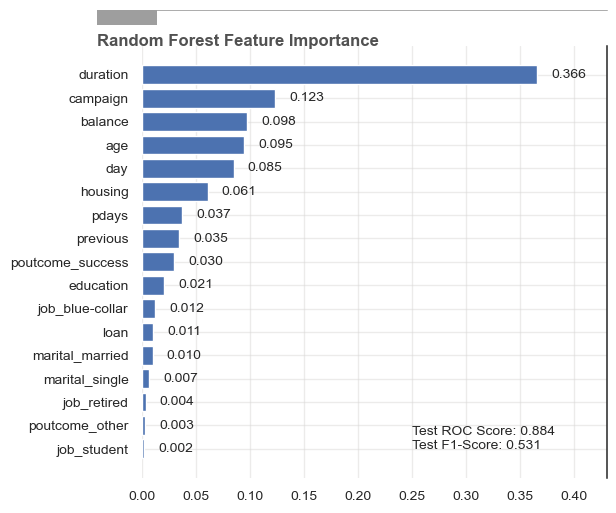

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
graph = ax.barh(rf_importance['Features'], rf_importance['Coeff'])

# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="Random Forest Feature Importance", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)


plt.annotate(('Test ROC Score: ' + str(round(rf_cv_auc,3)) + '\nTest F1-Score: ' + str(round(rf_cv_f1,3))),
             xy=(0.25,16), fontsize = 10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.3f', padding =10, fontsize = 10)
ax.set_xlim(right=0.43) 
ax.invert_yaxis()

plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.92, wspace=None, hspace=None)
plt.show()

#### XGBoost

In [38]:
param_grid = {'learning_rate':np.arange(0.01,0.3,0.05),
              'n_estimators':np.arange(100,250,50),
              'max_depth' : np.arange(3,11,3),
              'gamma':np.arange(0,1,0.2) } 

grid = GridSearchCV(xgb_over, param_grid=param_grid, cv=5, scoring='f1', verbose = 10)
grid.fit(X_train_over, y_train_over)
print(grid.best_params_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5; 1/270] START gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 1/5; 1/270] END gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.800 total time=   1.0s
[CV 2/5; 1/270] START gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 2/5; 1/270] END gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   0.9s
[CV 3/5; 1/270] START gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 3/5; 1/270] END gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.819 total time=   0.9s
[CV 4/5; 1/270] START gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 4/5; 1/270] END gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.814 total time=   0.9s
[CV 5/5; 1/270] START gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 5/5; 1/270] END gamma=0.0, learning_rate=0.01, max_depth=3, n

[CV 2/5; 9/270] END gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.902 total time=   7.9s
[CV 3/5; 9/270] START gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 3/5; 9/270] END gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.900 total time=   7.0s
[CV 4/5; 9/270] START gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 4/5; 9/270] END gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.897 total time=   6.9s
[CV 5/5; 9/270] START gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 5/5; 9/270] END gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.900 total time=   7.2s
[CV 1/5; 10/270] START gamma=0.0, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 1/5; 10/270] END gamma=0.0, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.825 total time=   1.0s
[CV 2/5; 10/270] START gamma=0.0, learning_rate=0.06000000000000

[CV 3/5; 16/270] END gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.934 total time=   3.7s
[CV 4/5; 16/270] START gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 4/5; 16/270] END gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.936 total time=   3.5s
[CV 5/5; 16/270] START gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 5/5; 16/270] END gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.938 total time=   3.9s
[CV 1/5; 17/270] START gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 1/5; 17/270] END gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.737 total time=   5.3s
[CV 2/5; 17/270] START gamma=0.0, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 2/5; 17/270] END gamma=0.0, learning_rate=0.060000000000000005, max_dept

[CV 3/5; 24/270] END gamma=0.0, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.962 total time=   4.1s
[CV 4/5; 24/270] START gamma=0.0, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 4/5; 24/270] END gamma=0.0, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.960 total time=   4.1s
[CV 5/5; 24/270] START gamma=0.0, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 5/5; 24/270] END gamma=0.0, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.965 total time=   4.1s
[CV 1/5; 25/270] START gamma=0.0, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 1/5; 25/270] END gamma=0.0, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.714 total time=   3.4s
[CV 2/5; 25/270] START gamma=0.0, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 2/5; 25/270] END gamma=0.0, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.956 total time=   3.3s
[CV 3/5; 25/270] START gamma=0.0, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 3

[CV 2/5; 32/270] END gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.962 total time=   3.3s
[CV 3/5; 32/270] START gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 3/5; 32/270] END gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.964 total time=   3.1s
[CV 4/5; 32/270] START gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 4/5; 32/270] END gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.963 total time=   3.6s
[CV 5/5; 32/270] START gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 5/5; 32/270] END gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.966 total time=   3.2s
[CV 1/5; 33/270] START gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_estimators=200
[CV 1/5; 33/270] END gamma=0.0, learning_rate=0.16000000000000003, max_depth=6, n_es

[CV 3/5; 39/270] END gamma=0.0, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   1.9s
[CV 4/5; 39/270] START gamma=0.0, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 4/5; 39/270] END gamma=0.0, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   1.9s
[CV 5/5; 39/270] START gamma=0.0, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 5/5; 39/270] END gamma=0.0, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.956 total time=   2.0s
[CV 1/5; 40/270] START gamma=0.0, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 1/5; 40/270] END gamma=0.0, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100;, score=0.613 total time=   2.0s
[CV 2/5; 40/270] START gamma=0.0, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 2/5; 40/270] END gamma=0.0, learning_rate=0.21000000000000002, max_depth=6, n_es

[CV 5/5; 46/270] END gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.941 total time=   1.0s
[CV 1/5; 47/270] START gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 1/5; 47/270] END gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.621 total time=   1.6s
[CV 2/5; 47/270] START gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 2/5; 47/270] END gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.955 total time=   1.6s
[CV 3/5; 47/270] START gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 3/5; 47/270] END gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.954 total time=   1.5s
[CV 4/5; 47/270] START gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 4/5; 47/270] END gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.953 total time=   1.5s
[CV 5/5; 47/270] START gamma=0.0, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 5

[CV 2/5; 55/270] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   1.1s
[CV 3/5; 55/270] START gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 3/5; 55/270] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.819 total time=   1.1s
[CV 4/5; 55/270] START gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 4/5; 55/270] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.814 total time=   1.1s
[CV 5/5; 55/270] START gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 5/5; 55/270] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.822 total time=   1.1s
[CV 1/5; 56/270] START gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=150
[CV 1/5; 56/270] END gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=150;, score=0.811 total time=   1.6s
[CV 2/5; 56/270] START gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=150
[CV 2

[CV 4/5; 63/270] END gamma=0.2, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.898 total time=   7.7s
[CV 5/5; 63/270] START gamma=0.2, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 5/5; 63/270] END gamma=0.2, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.901 total time=   7.4s
[CV 1/5; 64/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 1/5; 64/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.825 total time=   1.1s
[CV 2/5; 64/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 2/5; 64/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.885 total time=   1.1s
[CV 3/5; 64/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 3/5; 64/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.885 total time= 

[CV 5/5; 70/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.938 total time=   3.8s
[CV 1/5; 71/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 1/5; 71/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.744 total time=   5.3s
[CV 2/5; 71/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 2/5; 71/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.952 total time=   5.5s
[CV 3/5; 71/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 3/5; 71/270] END gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.952 total time=   5.0s
[CV 4/5; 71/270] START gamma=0.2, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 4/5; 71/270] END gamma=0.2, learning_rate=0.060000000000000005, max_dept

[CV 5/5; 78/270] END gamma=0.2, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.964 total time=   6.9s
[CV 1/5; 79/270] START gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 1/5; 79/270] END gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.695 total time=   4.5s
[CV 2/5; 79/270] START gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 2/5; 79/270] END gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.959 total time=   4.8s
[CV 3/5; 79/270] START gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 3/5; 79/270] END gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.958 total time=   4.0s
[CV 4/5; 79/270] START gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 4/5; 79/270] END gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.958 total time=   3.3s
[CV 5/5; 79/270] START gamma=0.2, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 5

[CV 3/5; 86/270] END gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.964 total time=   3.2s
[CV 4/5; 86/270] START gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 4/5; 86/270] END gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.964 total time=   3.1s
[CV 5/5; 86/270] START gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 5/5; 86/270] END gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.966 total time=   3.1s
[CV 1/5; 87/270] START gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=200
[CV 1/5; 87/270] END gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=200;, score=0.551 total time=   4.2s
[CV 2/5; 87/270] START gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_estimators=200
[CV 2/5; 87/270] END gamma=0.2, learning_rate=0.16000000000000003, max_depth=6, n_es

[CV 4/5; 93/270] END gamma=0.2, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.956 total time=   2.2s
[CV 5/5; 93/270] START gamma=0.2, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 5/5; 93/270] END gamma=0.2, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.956 total time=   2.7s
[CV 1/5; 94/270] START gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 1/5; 94/270] END gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100;, score=0.604 total time=   2.2s
[CV 2/5; 94/270] START gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 2/5; 94/270] END gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100;, score=0.959 total time=   2.2s
[CV 3/5; 94/270] START gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 3/5; 94/270] END gamma=0.2, learning_rate=0.21000000000000002, max_depth=6, n_es

[CV 1/5; 101/270] END gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.622 total time=   1.6s
[CV 2/5; 101/270] START gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 2/5; 101/270] END gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.956 total time=   1.7s
[CV 3/5; 101/270] START gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 3/5; 101/270] END gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.953 total time=   1.6s
[CV 4/5; 101/270] START gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 4/5; 101/270] END gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.952 total time=   1.5s
[CV 5/5; 101/270] START gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 5/5; 101/270] END gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.955 total time=   1.6s
[CV 1/5; 102/270] START gamma=0.2, learning_rate=0.26, max_depth=3, n_estimators

[CV 2/5; 109/270] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   1.2s
[CV 3/5; 109/270] START gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 3/5; 109/270] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.819 total time=   1.1s
[CV 4/5; 109/270] START gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 4/5; 109/270] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.814 total time=   1.1s
[CV 5/5; 109/270] START gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 5/5; 109/270] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.822 total time=   1.3s
[CV 1/5; 110/270] START gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=150
[CV 1/5; 110/270] END gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=150;, score=0.811 total time=   1.8s
[CV 2/5; 110/270] START gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators

[CV 3/5; 117/270] END gamma=0.4, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.900 total time=   7.7s
[CV 4/5; 117/270] START gamma=0.4, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 4/5; 117/270] END gamma=0.4, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.898 total time=   8.7s
[CV 5/5; 117/270] START gamma=0.4, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 5/5; 117/270] END gamma=0.4, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.900 total time=   7.9s
[CV 1/5; 118/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 1/5; 118/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.825 total time=   1.1s
[CV 2/5; 118/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100
[CV 2/5; 118/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=3, n_estimators=100;, score=0.885 total time=   1.0s
[CV 3/5; 118/270

[CV 4/5; 124/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.933 total time=   3.9s
[CV 5/5; 124/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 5/5; 124/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.938 total time=   3.7s
[CV 1/5; 125/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 1/5; 125/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.740 total time=   5.1s
[CV 2/5; 125/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 2/5; 125/270] END gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150;, score=0.950 total time=   5.1s
[CV 3/5; 125/270] START gamma=0.4, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 3/5; 125/270] END gamma=0.4, learning_rate=0.060000000000000005,

[CV 3/5; 132/270] END gamma=0.4, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.962 total time=   4.5s
[CV 4/5; 132/270] START gamma=0.4, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 4/5; 132/270] END gamma=0.4, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.963 total time=   4.4s
[CV 5/5; 132/270] START gamma=0.4, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 5/5; 132/270] END gamma=0.4, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.965 total time=   4.2s
[CV 1/5; 133/270] START gamma=0.4, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 1/5; 133/270] END gamma=0.4, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.699 total time=   3.3s
[CV 2/5; 133/270] START gamma=0.4, learning_rate=0.11, max_depth=9, n_estimators=100
[CV 2/5; 133/270] END gamma=0.4, learning_rate=0.11, max_depth=9, n_estimators=100;, score=0.956 total time=   3.4s
[CV 3/5; 133/270] START gamma=0.4, learning_rate=0.11, max_depth=9, n_estimators

[CV 1/5; 140/270] END gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.579 total time=   3.2s
[CV 2/5; 140/270] START gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 2/5; 140/270] END gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.962 total time=   3.1s
[CV 3/5; 140/270] START gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 3/5; 140/270] END gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.963 total time=   3.2s
[CV 4/5; 140/270] START gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 4/5; 140/270] END gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.963 total time=   3.2s
[CV 5/5; 140/270] START gamma=0.4, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 5/5; 140/270] END gamma=0.4, learning_rate=0.16000000000000003, max_dept

[CV 2/5; 147/270] END gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.957 total time=   2.2s
[CV 3/5; 147/270] START gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 3/5; 147/270] END gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   2.1s
[CV 4/5; 147/270] START gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 4/5; 147/270] END gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.954 total time=   2.1s
[CV 5/5; 147/270] START gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 5/5; 147/270] END gamma=0.4, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   2.1s
[CV 1/5; 148/270] START gamma=0.4, learning_rate=0.21000000000000002, max_depth=6, n_estimators=100
[CV 1/5; 148/270] END gamma=0.4, learning_rate=0.21000000000000002, max_dept

[CV 3/5; 154/270] END gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.938 total time=   1.2s
[CV 4/5; 154/270] START gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 4/5; 154/270] END gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.938 total time=   1.1s
[CV 5/5; 154/270] START gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 5/5; 154/270] END gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.941 total time=   1.1s
[CV 1/5; 155/270] START gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 1/5; 155/270] END gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.620 total time=   1.6s
[CV 2/5; 155/270] START gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 2/5; 155/270] END gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.956 total time=   2.8s
[CV 3/5; 155/270] START gamma=0.4, learning_rate=0.26, max_depth=3, n_estimators

[CV 4/5; 162/270] END gamma=0.4, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.969 total time=   6.1s
[CV 5/5; 162/270] START gamma=0.4, learning_rate=0.26, max_depth=9, n_estimators=200
[CV 5/5; 162/270] END gamma=0.4, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.971 total time=   6.2s
[CV 1/5; 163/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 1/5; 163/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.800 total time=   1.2s
[CV 2/5; 163/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 2/5; 163/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   1.4s
[CV 3/5; 163/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 3/5; 163/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.819 total tim

[CV 5/5; 169/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=100;, score=0.889 total time=   4.2s
[CV 1/5; 170/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150
[CV 1/5; 170/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150;, score=0.827 total time=   6.4s
[CV 2/5; 170/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150
[CV 2/5; 170/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150;, score=0.897 total time=   6.4s
[CV 3/5; 170/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150
[CV 3/5; 170/270] END gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150;, score=0.895 total time=   7.2s
[CV 4/5; 170/270] START gamma=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=150
[CV 4/5; 170/270] END gamma=0.6000000000000001, learning_rate=0.01, max_dept

[CV 3/5; 176/270] END gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=150;, score=0.934 total time=   3.5s
[CV 4/5; 176/270] START gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=150
[CV 4/5; 176/270] END gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=150;, score=0.930 total time=   3.4s
[CV 5/5; 176/270] START gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=150
[CV 5/5; 176/270] END gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=150;, score=0.936 total time=   3.3s
[CV 1/5; 177/270] START gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=200
[CV 1/5; 177/270] END gamma=0.6000000000000001, learning_rate=0.060000000000000005, max_depth=6, n_estimators=200;, score=0.731 total time=   4.7s
[CV 2/5; 177/270] START gamma=0.6000000000000001, learning_rate=

[CV 1/5; 183/270] END gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200;, score=0.746 total time=   2.1s
[CV 2/5; 183/270] START gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200
[CV 2/5; 183/270] END gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200;, score=0.932 total time=   2.1s
[CV 3/5; 183/270] START gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200
[CV 3/5; 183/270] END gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200;, score=0.929 total time=   2.1s
[CV 4/5; 183/270] START gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200
[CV 4/5; 183/270] END gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200;, score=0.930 total time=   2.1s
[CV 5/5; 183/270] START gamma=0.6000000000000001, learning_rate=0.11, max_depth=3, n_estimators=200
[CV 5/5; 183/270] END gamma=0.6000000000000001, learning_rate=0.11, max_dept

[CV 2/5; 190/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100;, score=0.919 total time=   1.0s
[CV 3/5; 190/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100
[CV 3/5; 190/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100;, score=0.918 total time=   1.1s
[CV 4/5; 190/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100
[CV 4/5; 190/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100;, score=0.916 total time=   1.1s
[CV 5/5; 190/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100
[CV 5/5; 190/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=3, n_estimators=100;, score=0.923 total time=   1.1s
[CV 1/5; 191/270] START gamma=0.6000000000000001, learning_rate=0.16000

[CV 4/5; 196/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=100;, score=0.964 total time=   3.4s
[CV 5/5; 196/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=100
[CV 5/5; 196/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=100;, score=0.968 total time=   3.9s
[CV 1/5; 197/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=150
[CV 1/5; 197/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=150;, score=0.570 total time=   5.7s
[CV 2/5; 197/270] START gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=150
[CV 2/5; 197/270] END gamma=0.6000000000000001, learning_rate=0.16000000000000003, max_depth=9, n_estimators=150;, score=0.970 total time=   5.3s
[CV 3/5; 197/270] START gamma=0.6000000000000001, learning_rate=0.16000

[CV 1/5; 203/270] END gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150;, score=0.557 total time=   3.3s
[CV 2/5; 203/270] START gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150
[CV 2/5; 203/270] END gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150;, score=0.967 total time=   3.3s
[CV 3/5; 203/270] START gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150
[CV 3/5; 203/270] END gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150;, score=0.967 total time=   3.2s
[CV 4/5; 203/270] START gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150
[CV 4/5; 203/270] END gamma=0.6000000000000001, learning_rate=0.21000000000000002, max_depth=6, n_estimators=150;, score=0.967 total time=   3.3s
[CV 5/5; 203/270] START gamma=0.6000000000000001, learning_rate=0.21000

[CV 4/5; 209/270] END gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.953 total time=   1.6s
[CV 5/5; 209/270] START gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=150
[CV 5/5; 209/270] END gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=150;, score=0.956 total time=   1.6s
[CV 1/5; 210/270] START gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=200
[CV 1/5; 210/270] END gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=200;, score=0.576 total time=   2.3s
[CV 2/5; 210/270] START gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=200
[CV 2/5; 210/270] END gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=200;, score=0.962 total time=   2.2s
[CV 3/5; 210/270] START gamma=0.6000000000000001, learning_rate=0.26, max_depth=3, n_estimators=200
[CV 3/5; 210/270] END gamma=0.6000000000000001, learning_rate=0.26, max_dept

[CV 5/5; 216/270] END gamma=0.6000000000000001, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.974 total time=   6.3s
[CV 1/5; 217/270] START gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 1/5; 217/270] END gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.800 total time=   1.1s
[CV 2/5; 217/270] START gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 2/5; 217/270] END gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   1.1s
[CV 3/5; 217/270] START gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 3/5; 217/270] END gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.819 total time=   1.1s
[CV 4/5; 217/270] START gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100
[CV 4/5; 217/270] END gamma=0.8, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.814 total time=   1.1s
[CV 5/5; 217/270] START gamma=0.8, learning_rate=0.01, max_depth=

[CV 1/5; 225/270] END gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.830 total time=   7.8s
[CV 2/5; 225/270] START gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 2/5; 225/270] END gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.902 total time=   7.7s
[CV 3/5; 225/270] START gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 3/5; 225/270] END gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.900 total time=   8.0s
[CV 4/5; 225/270] START gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 4/5; 225/270] END gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.897 total time=   8.1s
[CV 5/5; 225/270] START gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200
[CV 5/5; 225/270] END gamma=0.8, learning_rate=0.01, max_depth=9, n_estimators=200;, score=0.901 total time=   7.9s
[CV 1/5; 226/270] START gamma=0.8, learning_rate=0.060000000000000005, max_depth

[CV 2/5; 232/270] END gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.938 total time=   3.7s
[CV 3/5; 232/270] START gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 3/5; 232/270] END gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.934 total time=   3.9s
[CV 4/5; 232/270] START gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 4/5; 232/270] END gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.933 total time=   3.8s
[CV 5/5; 232/270] START gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100
[CV 5/5; 232/270] END gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=100;, score=0.939 total time=   3.7s
[CV 1/5; 233/270] START gamma=0.8, learning_rate=0.060000000000000005, max_depth=9, n_estimators=150
[CV 1/5; 233/270] END gamma=0.8, learning_rate=0.060000000000000005,

[CV 1/5; 240/270] END gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.608 total time=   4.2s
[CV 2/5; 240/270] START gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 2/5; 240/270] END gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.962 total time=   4.1s
[CV 3/5; 240/270] START gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 3/5; 240/270] END gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.960 total time=   4.1s
[CV 4/5; 240/270] START gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 4/5; 240/270] END gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.962 total time=   4.1s
[CV 5/5; 240/270] START gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200
[CV 5/5; 240/270] END gamma=0.8, learning_rate=0.11, max_depth=6, n_estimators=200;, score=0.964 total time=   4.1s
[CV 1/5; 241/270] START gamma=0.8, learning_rate=0.11, max_depth=9, n_estimators

[CV 4/5; 247/270] END gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=100;, score=0.954 total time=   2.1s
[CV 5/5; 247/270] START gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=100
[CV 5/5; 247/270] END gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=100;, score=0.960 total time=   2.8s
[CV 1/5; 248/270] START gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 1/5; 248/270] END gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.588 total time=   3.5s
[CV 2/5; 248/270] START gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 2/5; 248/270] END gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150;, score=0.962 total time=   3.1s
[CV 3/5; 248/270] START gamma=0.8, learning_rate=0.16000000000000003, max_depth=6, n_estimators=150
[CV 3/5; 248/270] END gamma=0.8, learning_rate=0.16000000000000003, max_dept

[CV 5/5; 254/270] END gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=150;, score=0.950 total time=   1.8s
[CV 1/5; 255/270] START gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 1/5; 255/270] END gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.611 total time=   2.4s
[CV 2/5; 255/270] START gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 2/5; 255/270] END gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   2.4s
[CV 3/5; 255/270] START gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 3/5; 255/270] END gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200;, score=0.955 total time=   2.3s
[CV 4/5; 255/270] START gamma=0.8, learning_rate=0.21000000000000002, max_depth=3, n_estimators=200
[CV 4/5; 255/270] END gamma=0.8, learning_rate=0.21000000000000002, max_dept

[CV 1/5; 262/270] END gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.716 total time=   1.2s
[CV 2/5; 262/270] START gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 2/5; 262/270] END gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.941 total time=   1.2s
[CV 3/5; 262/270] START gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 3/5; 262/270] END gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.938 total time=   1.1s
[CV 4/5; 262/270] START gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 4/5; 262/270] END gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.938 total time=   1.2s
[CV 5/5; 262/270] START gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100
[CV 5/5; 262/270] END gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators=100;, score=0.940 total time=   1.0s
[CV 1/5; 263/270] START gamma=0.8, learning_rate=0.26, max_depth=3, n_estimators

[CV 2/5; 270/270] END gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.970 total time=   6.8s
[CV 3/5; 270/270] START gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200
[CV 3/5; 270/270] END gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.970 total time=   6.5s
[CV 4/5; 270/270] START gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200
[CV 4/5; 270/270] END gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.971 total time=   7.3s
[CV 5/5; 270/270] START gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200
[CV 5/5; 270/270] END gamma=0.8, learning_rate=0.26, max_depth=9, n_estimators=200;, score=0.972 total time=   7.4s
{'gamma': 0.8, 'learning_rate': 0.060000000000000005, 'max_depth': 9, 'n_estimators': 150}


In [39]:
xgb_cv = XGBClassifier(**grid.best_params_, random_state= 100)
xgb_cv_auc, xgb_cv_f1, xgb_cv_fpr, xgb_cv_tpr, xgb_cv_precision, xgb_cv_recall = performance_measure_cv(xgb_cv)

f1_score = 0.53522
roc_auc_score = 0.89173
Accuracy = 0.88765
Precision = 0.51003
TPR = 0.56304
FNR = 0.43696
TNR = 0.92979
FPR = 0.070215


In [40]:
xgb_importance = pd.DataFrame(list(zip(xgb_cv.feature_names_in_, xgb_cv.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
xgb_importance

,Features,Coeff
0,housing,0.234557
1,poutcome_success,0.208161
2,duration,0.140311
3,campaign,0.087548
4,job_blue-collar,0.040534
5,day,0.040034
6,previous,0.038589
7,loan,0.038180
8,pdays,0.037483
9,age,0.022129


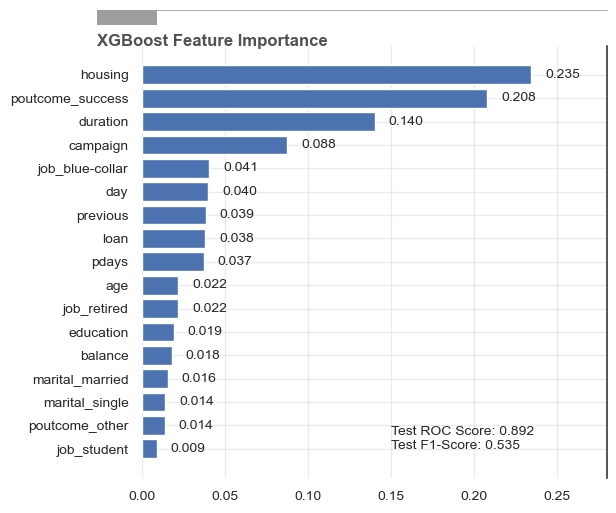

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
graph = ax.barh(xgb_importance['Features'], xgb_importance['Coeff'])

# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="XGBoost Feature Importance", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)

plt.annotate(('Test ROC Score: ' + str(round(xgb_cv_auc,3)) + '\nTest F1-Score: ' + str(round(xgb_cv_f1,3))),
             xy=(0.15,16), fontsize = 10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.3f', padding =10, fontsize = 10)
ax.set_xlim(right=0.28) 
ax.invert_yaxis()

plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.92, wspace=None, hspace=None)
plt.show()


#### Decision Tree Classifier

In [42]:
param_grid = {'max_depth':[2,3,6,9,12],
             'min_samples_split':np.arange(2,20,2),
              'min_samples_leaf':np.arange(1,10,2)} 

grid = GridSearchCV(dt_over, param_grid=param_grid, cv=5, scoring='f1', verbose = 10)
grid.fit(X_train_over, y_train_over)
print(grid.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV 1/5; 1/225] START max_depth=2, min_samples_leaf=1, min_samples_split=2......
[CV 1/5; 1/225] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.764 total time=   0.0s
[CV 2/5; 1/225] START max_depth=2, min_samples_leaf=1, min_samples_split=2......
[CV 2/5; 1/225] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 3/5; 1/225] START max_depth=2, min_samples_leaf=1, min_samples_split=2......
[CV 3/5; 1/225] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 4/5; 1/225] START max_depth=2, min_samples_leaf=1, min_samples_split=2......
[CV 4/5; 1/225] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.766 total time=   0.0s
[CV 5/5; 1/225] START max_depth=2, min_samples_leaf=1, min_samples_split=2......
[CV 5/5; 1/225] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.773 total time=   0.0s
[

[CV 4/5; 9/225] END max_depth=2, min_samples_leaf=1, min_samples_split=18;, score=0.766 total time=   0.0s
[CV 5/5; 9/225] START max_depth=2, min_samples_leaf=1, min_samples_split=18.....
[CV 5/5; 9/225] END max_depth=2, min_samples_leaf=1, min_samples_split=18;, score=0.773 total time=   0.0s
[CV 1/5; 10/225] START max_depth=2, min_samples_leaf=3, min_samples_split=2.....
[CV 1/5; 10/225] END max_depth=2, min_samples_leaf=3, min_samples_split=2;, score=0.764 total time=   0.0s
[CV 2/5; 10/225] START max_depth=2, min_samples_leaf=3, min_samples_split=2.....
[CV 2/5; 10/225] END max_depth=2, min_samples_leaf=3, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 3/5; 10/225] START max_depth=2, min_samples_leaf=3, min_samples_split=2.....
[CV 3/5; 10/225] END max_depth=2, min_samples_leaf=3, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 4/5; 10/225] START max_depth=2, min_samples_leaf=3, min_samples_split=2.....
[CV 4/5; 10/225] END max_depth=2, min_samples_leaf=3, min_sa

[CV 3/5; 18/225] END max_depth=2, min_samples_leaf=3, min_samples_split=18;, score=0.774 total time=   0.0s
[CV 4/5; 18/225] START max_depth=2, min_samples_leaf=3, min_samples_split=18....
[CV 4/5; 18/225] END max_depth=2, min_samples_leaf=3, min_samples_split=18;, score=0.766 total time=   0.0s
[CV 5/5; 18/225] START max_depth=2, min_samples_leaf=3, min_samples_split=18....
[CV 5/5; 18/225] END max_depth=2, min_samples_leaf=3, min_samples_split=18;, score=0.773 total time=   0.0s
[CV 1/5; 19/225] START max_depth=2, min_samples_leaf=5, min_samples_split=2.....
[CV 1/5; 19/225] END max_depth=2, min_samples_leaf=5, min_samples_split=2;, score=0.764 total time=   0.0s
[CV 2/5; 19/225] START max_depth=2, min_samples_leaf=5, min_samples_split=2.....
[CV 2/5; 19/225] END max_depth=2, min_samples_leaf=5, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 3/5; 19/225] START max_depth=2, min_samples_leaf=5, min_samples_split=2.....
[CV 3/5; 19/225] END max_depth=2, min_samples_leaf=5, min

[CV 3/5; 27/225] END max_depth=2, min_samples_leaf=5, min_samples_split=18;, score=0.774 total time=   0.0s
[CV 4/5; 27/225] START max_depth=2, min_samples_leaf=5, min_samples_split=18....
[CV 4/5; 27/225] END max_depth=2, min_samples_leaf=5, min_samples_split=18;, score=0.766 total time=   0.0s
[CV 5/5; 27/225] START max_depth=2, min_samples_leaf=5, min_samples_split=18....
[CV 5/5; 27/225] END max_depth=2, min_samples_leaf=5, min_samples_split=18;, score=0.773 total time=   0.0s
[CV 1/5; 28/225] START max_depth=2, min_samples_leaf=7, min_samples_split=2.....
[CV 1/5; 28/225] END max_depth=2, min_samples_leaf=7, min_samples_split=2;, score=0.764 total time=   0.0s
[CV 2/5; 28/225] START max_depth=2, min_samples_leaf=7, min_samples_split=2.....
[CV 2/5; 28/225] END max_depth=2, min_samples_leaf=7, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 3/5; 28/225] START max_depth=2, min_samples_leaf=7, min_samples_split=2.....
[CV 3/5; 28/225] END max_depth=2, min_samples_leaf=7, min

[CV 4/5; 36/225] END max_depth=2, min_samples_leaf=7, min_samples_split=18;, score=0.766 total time=   0.0s
[CV 5/5; 36/225] START max_depth=2, min_samples_leaf=7, min_samples_split=18....
[CV 5/5; 36/225] END max_depth=2, min_samples_leaf=7, min_samples_split=18;, score=0.773 total time=   0.0s
[CV 1/5; 37/225] START max_depth=2, min_samples_leaf=9, min_samples_split=2.....
[CV 1/5; 37/225] END max_depth=2, min_samples_leaf=9, min_samples_split=2;, score=0.764 total time=   0.0s
[CV 2/5; 37/225] START max_depth=2, min_samples_leaf=9, min_samples_split=2.....
[CV 2/5; 37/225] END max_depth=2, min_samples_leaf=9, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 3/5; 37/225] START max_depth=2, min_samples_leaf=9, min_samples_split=2.....
[CV 3/5; 37/225] END max_depth=2, min_samples_leaf=9, min_samples_split=2;, score=0.774 total time=   0.0s
[CV 4/5; 37/225] START max_depth=2, min_samples_leaf=9, min_samples_split=2.....
[CV 4/5; 37/225] END max_depth=2, min_samples_leaf=9, min_

[CV 4/5; 45/225] END max_depth=2, min_samples_leaf=9, min_samples_split=18;, score=0.766 total time=   0.0s
[CV 5/5; 45/225] START max_depth=2, min_samples_leaf=9, min_samples_split=18....
[CV 5/5; 45/225] END max_depth=2, min_samples_leaf=9, min_samples_split=18;, score=0.773 total time=   0.0s
[CV 1/5; 46/225] START max_depth=3, min_samples_leaf=1, min_samples_split=2.....
[CV 1/5; 46/225] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.789 total time=   0.0s
[CV 2/5; 46/225] START max_depth=3, min_samples_leaf=1, min_samples_split=2.....
[CV 2/5; 46/225] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 3/5; 46/225] START max_depth=3, min_samples_leaf=1, min_samples_split=2.....
[CV 3/5; 46/225] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 4/5; 46/225] START max_depth=3, min_samples_leaf=1, min_samples_split=2.....
[CV 4/5; 46/225] END max_depth=3, min_samples_leaf=1, min_

[CV 4/5; 54/225] END max_depth=3, min_samples_leaf=1, min_samples_split=18;, score=0.791 total time=   0.0s
[CV 5/5; 54/225] START max_depth=3, min_samples_leaf=1, min_samples_split=18....
[CV 5/5; 54/225] END max_depth=3, min_samples_leaf=1, min_samples_split=18;, score=0.798 total time=   0.0s
[CV 1/5; 55/225] START max_depth=3, min_samples_leaf=3, min_samples_split=2.....
[CV 1/5; 55/225] END max_depth=3, min_samples_leaf=3, min_samples_split=2;, score=0.789 total time=   0.0s
[CV 2/5; 55/225] START max_depth=3, min_samples_leaf=3, min_samples_split=2.....
[CV 2/5; 55/225] END max_depth=3, min_samples_leaf=3, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 3/5; 55/225] START max_depth=3, min_samples_leaf=3, min_samples_split=2.....
[CV 3/5; 55/225] END max_depth=3, min_samples_leaf=3, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 4/5; 55/225] START max_depth=3, min_samples_leaf=3, min_samples_split=2.....
[CV 4/5; 55/225] END max_depth=3, min_samples_leaf=3, min_

[CV 3/5; 63/225] END max_depth=3, min_samples_leaf=3, min_samples_split=18;, score=0.794 total time=   0.0s
[CV 4/5; 63/225] START max_depth=3, min_samples_leaf=3, min_samples_split=18....
[CV 4/5; 63/225] END max_depth=3, min_samples_leaf=3, min_samples_split=18;, score=0.791 total time=   0.0s
[CV 5/5; 63/225] START max_depth=3, min_samples_leaf=3, min_samples_split=18....
[CV 5/5; 63/225] END max_depth=3, min_samples_leaf=3, min_samples_split=18;, score=0.798 total time=   0.0s
[CV 1/5; 64/225] START max_depth=3, min_samples_leaf=5, min_samples_split=2.....
[CV 1/5; 64/225] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.789 total time=   0.0s
[CV 2/5; 64/225] START max_depth=3, min_samples_leaf=5, min_samples_split=2.....
[CV 2/5; 64/225] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 3/5; 64/225] START max_depth=3, min_samples_leaf=5, min_samples_split=2.....
[CV 3/5; 64/225] END max_depth=3, min_samples_leaf=5, min

[CV 3/5; 72/225] END max_depth=3, min_samples_leaf=5, min_samples_split=18;, score=0.794 total time=   0.0s
[CV 4/5; 72/225] START max_depth=3, min_samples_leaf=5, min_samples_split=18....
[CV 4/5; 72/225] END max_depth=3, min_samples_leaf=5, min_samples_split=18;, score=0.791 total time=   0.0s
[CV 5/5; 72/225] START max_depth=3, min_samples_leaf=5, min_samples_split=18....
[CV 5/5; 72/225] END max_depth=3, min_samples_leaf=5, min_samples_split=18;, score=0.798 total time=   0.0s
[CV 1/5; 73/225] START max_depth=3, min_samples_leaf=7, min_samples_split=2.....
[CV 1/5; 73/225] END max_depth=3, min_samples_leaf=7, min_samples_split=2;, score=0.789 total time=   0.0s
[CV 2/5; 73/225] START max_depth=3, min_samples_leaf=7, min_samples_split=2.....
[CV 2/5; 73/225] END max_depth=3, min_samples_leaf=7, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 3/5; 73/225] START max_depth=3, min_samples_leaf=7, min_samples_split=2.....
[CV 3/5; 73/225] END max_depth=3, min_samples_leaf=7, min

[CV 4/5; 81/225] END max_depth=3, min_samples_leaf=7, min_samples_split=18;, score=0.791 total time=   0.0s
[CV 5/5; 81/225] START max_depth=3, min_samples_leaf=7, min_samples_split=18....
[CV 5/5; 81/225] END max_depth=3, min_samples_leaf=7, min_samples_split=18;, score=0.798 total time=   0.0s
[CV 1/5; 82/225] START max_depth=3, min_samples_leaf=9, min_samples_split=2.....
[CV 1/5; 82/225] END max_depth=3, min_samples_leaf=9, min_samples_split=2;, score=0.789 total time=   0.0s
[CV 2/5; 82/225] START max_depth=3, min_samples_leaf=9, min_samples_split=2.....
[CV 2/5; 82/225] END max_depth=3, min_samples_leaf=9, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 3/5; 82/225] START max_depth=3, min_samples_leaf=9, min_samples_split=2.....
[CV 3/5; 82/225] END max_depth=3, min_samples_leaf=9, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 4/5; 82/225] START max_depth=3, min_samples_leaf=9, min_samples_split=2.....
[CV 4/5; 82/225] END max_depth=3, min_samples_leaf=9, min_

[CV 5/5; 90/225] END max_depth=3, min_samples_leaf=9, min_samples_split=18;, score=0.798 total time=   0.0s
[CV 1/5; 91/225] START max_depth=6, min_samples_leaf=1, min_samples_split=2.....
[CV 1/5; 91/225] END max_depth=6, min_samples_leaf=1, min_samples_split=2;, score=0.811 total time=   0.1s
[CV 2/5; 91/225] START max_depth=6, min_samples_leaf=1, min_samples_split=2.....
[CV 2/5; 91/225] END max_depth=6, min_samples_leaf=1, min_samples_split=2;, score=0.842 total time=   0.1s
[CV 3/5; 91/225] START max_depth=6, min_samples_leaf=1, min_samples_split=2.....
[CV 3/5; 91/225] END max_depth=6, min_samples_leaf=1, min_samples_split=2;, score=0.848 total time=   0.1s
[CV 4/5; 91/225] START max_depth=6, min_samples_leaf=1, min_samples_split=2.....
[CV 4/5; 91/225] END max_depth=6, min_samples_leaf=1, min_samples_split=2;, score=0.844 total time=   0.1s
[CV 5/5; 91/225] START max_depth=6, min_samples_leaf=1, min_samples_split=2.....
[CV 5/5; 91/225] END max_depth=6, min_samples_leaf=1, min_s

[CV 5/5; 99/225] END max_depth=6, min_samples_leaf=1, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 1/5; 100/225] START max_depth=6, min_samples_leaf=3, min_samples_split=2....
[CV 1/5; 100/225] END max_depth=6, min_samples_leaf=3, min_samples_split=2;, score=0.810 total time=   0.1s
[CV 2/5; 100/225] START max_depth=6, min_samples_leaf=3, min_samples_split=2....
[CV 2/5; 100/225] END max_depth=6, min_samples_leaf=3, min_samples_split=2;, score=0.842 total time=   0.1s
[CV 3/5; 100/225] START max_depth=6, min_samples_leaf=3, min_samples_split=2....
[CV 3/5; 100/225] END max_depth=6, min_samples_leaf=3, min_samples_split=2;, score=0.848 total time=   0.1s
[CV 4/5; 100/225] START max_depth=6, min_samples_leaf=3, min_samples_split=2....
[CV 4/5; 100/225] END max_depth=6, min_samples_leaf=3, min_samples_split=2;, score=0.844 total time=   0.1s
[CV 5/5; 100/225] START max_depth=6, min_samples_leaf=3, min_samples_split=2....
[CV 5/5; 100/225] END max_depth=6, min_samples_leaf=3, 

[CV 5/5; 108/225] END max_depth=6, min_samples_leaf=3, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 1/5; 109/225] START max_depth=6, min_samples_leaf=5, min_samples_split=2....
[CV 1/5; 109/225] END max_depth=6, min_samples_leaf=5, min_samples_split=2;, score=0.810 total time=   0.1s
[CV 2/5; 109/225] START max_depth=6, min_samples_leaf=5, min_samples_split=2....
[CV 2/5; 109/225] END max_depth=6, min_samples_leaf=5, min_samples_split=2;, score=0.842 total time=   0.1s
[CV 3/5; 109/225] START max_depth=6, min_samples_leaf=5, min_samples_split=2....
[CV 3/5; 109/225] END max_depth=6, min_samples_leaf=5, min_samples_split=2;, score=0.848 total time=   0.1s
[CV 4/5; 109/225] START max_depth=6, min_samples_leaf=5, min_samples_split=2....
[CV 4/5; 109/225] END max_depth=6, min_samples_leaf=5, min_samples_split=2;, score=0.844 total time=   0.1s
[CV 5/5; 109/225] START max_depth=6, min_samples_leaf=5, min_samples_split=2....
[CV 5/5; 109/225] END max_depth=6, min_samples_leaf=5,

[CV 4/5; 117/225] END max_depth=6, min_samples_leaf=5, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 5/5; 117/225] START max_depth=6, min_samples_leaf=5, min_samples_split=18...
[CV 5/5; 117/225] END max_depth=6, min_samples_leaf=5, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 1/5; 118/225] START max_depth=6, min_samples_leaf=7, min_samples_split=2....
[CV 1/5; 118/225] END max_depth=6, min_samples_leaf=7, min_samples_split=2;, score=0.810 total time=   0.1s
[CV 2/5; 118/225] START max_depth=6, min_samples_leaf=7, min_samples_split=2....
[CV 2/5; 118/225] END max_depth=6, min_samples_leaf=7, min_samples_split=2;, score=0.842 total time=   0.1s
[CV 3/5; 118/225] START max_depth=6, min_samples_leaf=7, min_samples_split=2....
[CV 3/5; 118/225] END max_depth=6, min_samples_leaf=7, min_samples_split=2;, score=0.848 total time=   0.1s
[CV 4/5; 118/225] START max_depth=6, min_samples_leaf=7, min_samples_split=2....
[CV 4/5; 118/225] END max_depth=6, min_samples_leaf=7

[CV 3/5; 126/225] END max_depth=6, min_samples_leaf=7, min_samples_split=18;, score=0.848 total time=   0.1s
[CV 4/5; 126/225] START max_depth=6, min_samples_leaf=7, min_samples_split=18...
[CV 4/5; 126/225] END max_depth=6, min_samples_leaf=7, min_samples_split=18;, score=0.843 total time=   0.1s
[CV 5/5; 126/225] START max_depth=6, min_samples_leaf=7, min_samples_split=18...
[CV 5/5; 126/225] END max_depth=6, min_samples_leaf=7, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 1/5; 127/225] START max_depth=6, min_samples_leaf=9, min_samples_split=2....
[CV 1/5; 127/225] END max_depth=6, min_samples_leaf=9, min_samples_split=2;, score=0.810 total time=   0.1s
[CV 2/5; 127/225] START max_depth=6, min_samples_leaf=9, min_samples_split=2....
[CV 2/5; 127/225] END max_depth=6, min_samples_leaf=9, min_samples_split=2;, score=0.842 total time=   0.1s
[CV 3/5; 127/225] START max_depth=6, min_samples_leaf=9, min_samples_split=2....
[CV 3/5; 127/225] END max_depth=6, min_samples_leaf=

[CV 2/5; 135/225] END max_depth=6, min_samples_leaf=9, min_samples_split=18;, score=0.842 total time=   0.1s
[CV 3/5; 135/225] START max_depth=6, min_samples_leaf=9, min_samples_split=18...
[CV 3/5; 135/225] END max_depth=6, min_samples_leaf=9, min_samples_split=18;, score=0.848 total time=   0.1s
[CV 4/5; 135/225] START max_depth=6, min_samples_leaf=9, min_samples_split=18...
[CV 4/5; 135/225] END max_depth=6, min_samples_leaf=9, min_samples_split=18;, score=0.843 total time=   0.1s
[CV 5/5; 135/225] START max_depth=6, min_samples_leaf=9, min_samples_split=18...
[CV 5/5; 135/225] END max_depth=6, min_samples_leaf=9, min_samples_split=18;, score=0.844 total time=   0.1s
[CV 1/5; 136/225] START max_depth=9, min_samples_leaf=1, min_samples_split=2....
[CV 1/5; 136/225] END max_depth=9, min_samples_leaf=1, min_samples_split=2;, score=0.817 total time=   0.1s
[CV 2/5; 136/225] START max_depth=9, min_samples_leaf=1, min_samples_split=2....
[CV 2/5; 136/225] END max_depth=9, min_samples_leaf

[CV 1/5; 144/225] END max_depth=9, min_samples_leaf=1, min_samples_split=18;, score=0.816 total time=   0.1s
[CV 2/5; 144/225] START max_depth=9, min_samples_leaf=1, min_samples_split=18...
[CV 2/5; 144/225] END max_depth=9, min_samples_leaf=1, min_samples_split=18;, score=0.869 total time=   0.1s
[CV 3/5; 144/225] START max_depth=9, min_samples_leaf=1, min_samples_split=18...
[CV 3/5; 144/225] END max_depth=9, min_samples_leaf=1, min_samples_split=18;, score=0.870 total time=   0.1s
[CV 4/5; 144/225] START max_depth=9, min_samples_leaf=1, min_samples_split=18...
[CV 4/5; 144/225] END max_depth=9, min_samples_leaf=1, min_samples_split=18;, score=0.871 total time=   0.1s
[CV 5/5; 144/225] START max_depth=9, min_samples_leaf=1, min_samples_split=18...
[CV 5/5; 144/225] END max_depth=9, min_samples_leaf=1, min_samples_split=18;, score=0.871 total time=   0.1s
[CV 1/5; 145/225] START max_depth=9, min_samples_leaf=3, min_samples_split=2....
[CV 1/5; 145/225] END max_depth=9, min_samples_lea

[CV 5/5; 152/225] END max_depth=9, min_samples_leaf=3, min_samples_split=16;, score=0.871 total time=   0.1s
[CV 1/5; 153/225] START max_depth=9, min_samples_leaf=3, min_samples_split=18...
[CV 1/5; 153/225] END max_depth=9, min_samples_leaf=3, min_samples_split=18;, score=0.815 total time=   0.2s
[CV 2/5; 153/225] START max_depth=9, min_samples_leaf=3, min_samples_split=18...
[CV 2/5; 153/225] END max_depth=9, min_samples_leaf=3, min_samples_split=18;, score=0.869 total time=   0.1s
[CV 3/5; 153/225] START max_depth=9, min_samples_leaf=3, min_samples_split=18...
[CV 3/5; 153/225] END max_depth=9, min_samples_leaf=3, min_samples_split=18;, score=0.870 total time=   0.1s
[CV 4/5; 153/225] START max_depth=9, min_samples_leaf=3, min_samples_split=18...
[CV 4/5; 153/225] END max_depth=9, min_samples_leaf=3, min_samples_split=18;, score=0.872 total time=   0.2s
[CV 5/5; 153/225] START max_depth=9, min_samples_leaf=3, min_samples_split=18...
[CV 5/5; 153/225] END max_depth=9, min_samples_lea

[CV 4/5; 161/225] END max_depth=9, min_samples_leaf=5, min_samples_split=16;, score=0.871 total time=   0.1s
[CV 5/5; 161/225] START max_depth=9, min_samples_leaf=5, min_samples_split=16...
[CV 5/5; 161/225] END max_depth=9, min_samples_leaf=5, min_samples_split=16;, score=0.870 total time=   0.1s
[CV 1/5; 162/225] START max_depth=9, min_samples_leaf=5, min_samples_split=18...
[CV 1/5; 162/225] END max_depth=9, min_samples_leaf=5, min_samples_split=18;, score=0.815 total time=   0.1s
[CV 2/5; 162/225] START max_depth=9, min_samples_leaf=5, min_samples_split=18...
[CV 2/5; 162/225] END max_depth=9, min_samples_leaf=5, min_samples_split=18;, score=0.868 total time=   0.1s
[CV 3/5; 162/225] START max_depth=9, min_samples_leaf=5, min_samples_split=18...
[CV 3/5; 162/225] END max_depth=9, min_samples_leaf=5, min_samples_split=18;, score=0.869 total time=   0.1s
[CV 4/5; 162/225] START max_depth=9, min_samples_leaf=5, min_samples_split=18...
[CV 4/5; 162/225] END max_depth=9, min_samples_lea

[CV 3/5; 170/225] END max_depth=9, min_samples_leaf=7, min_samples_split=16;, score=0.869 total time=   0.1s
[CV 4/5; 170/225] START max_depth=9, min_samples_leaf=7, min_samples_split=16...
[CV 4/5; 170/225] END max_depth=9, min_samples_leaf=7, min_samples_split=16;, score=0.870 total time=   0.1s
[CV 5/5; 170/225] START max_depth=9, min_samples_leaf=7, min_samples_split=16...
[CV 5/5; 170/225] END max_depth=9, min_samples_leaf=7, min_samples_split=16;, score=0.870 total time=   0.1s
[CV 1/5; 171/225] START max_depth=9, min_samples_leaf=7, min_samples_split=18...
[CV 1/5; 171/225] END max_depth=9, min_samples_leaf=7, min_samples_split=18;, score=0.814 total time=   0.1s
[CV 2/5; 171/225] START max_depth=9, min_samples_leaf=7, min_samples_split=18...
[CV 2/5; 171/225] END max_depth=9, min_samples_leaf=7, min_samples_split=18;, score=0.868 total time=   0.1s
[CV 3/5; 171/225] START max_depth=9, min_samples_leaf=7, min_samples_split=18...
[CV 3/5; 171/225] END max_depth=9, min_samples_lea

[CV 2/5; 179/225] END max_depth=9, min_samples_leaf=9, min_samples_split=16;, score=0.868 total time=   0.1s
[CV 3/5; 179/225] START max_depth=9, min_samples_leaf=9, min_samples_split=16...
[CV 3/5; 179/225] END max_depth=9, min_samples_leaf=9, min_samples_split=16;, score=0.868 total time=   0.1s
[CV 4/5; 179/225] START max_depth=9, min_samples_leaf=9, min_samples_split=16...
[CV 4/5; 179/225] END max_depth=9, min_samples_leaf=9, min_samples_split=16;, score=0.870 total time=   0.1s
[CV 5/5; 179/225] START max_depth=9, min_samples_leaf=9, min_samples_split=16...
[CV 5/5; 179/225] END max_depth=9, min_samples_leaf=9, min_samples_split=16;, score=0.870 total time=   0.1s
[CV 1/5; 180/225] START max_depth=9, min_samples_leaf=9, min_samples_split=18...
[CV 1/5; 180/225] END max_depth=9, min_samples_leaf=9, min_samples_split=18;, score=0.814 total time=   0.1s
[CV 2/5; 180/225] START max_depth=9, min_samples_leaf=9, min_samples_split=18...
[CV 2/5; 180/225] END max_depth=9, min_samples_lea

[CV 1/5; 188/225] END max_depth=12, min_samples_leaf=1, min_samples_split=16;, score=0.803 total time=   0.2s
[CV 2/5; 188/225] START max_depth=12, min_samples_leaf=1, min_samples_split=16..
[CV 2/5; 188/225] END max_depth=12, min_samples_leaf=1, min_samples_split=16;, score=0.885 total time=   0.2s
[CV 3/5; 188/225] START max_depth=12, min_samples_leaf=1, min_samples_split=16..
[CV 3/5; 188/225] END max_depth=12, min_samples_leaf=1, min_samples_split=16;, score=0.885 total time=   0.2s
[CV 4/5; 188/225] START max_depth=12, min_samples_leaf=1, min_samples_split=16..
[CV 4/5; 188/225] END max_depth=12, min_samples_leaf=1, min_samples_split=16;, score=0.885 total time=   0.2s
[CV 5/5; 188/225] START max_depth=12, min_samples_leaf=1, min_samples_split=16..
[CV 5/5; 188/225] END max_depth=12, min_samples_leaf=1, min_samples_split=16;, score=0.890 total time=   0.2s
[CV 1/5; 189/225] START max_depth=12, min_samples_leaf=1, min_samples_split=18..
[CV 1/5; 189/225] END max_depth=12, min_sampl

[CV 4/5; 196/225] END max_depth=12, min_samples_leaf=3, min_samples_split=14;, score=0.884 total time=   0.2s
[CV 5/5; 196/225] START max_depth=12, min_samples_leaf=3, min_samples_split=14..
[CV 5/5; 196/225] END max_depth=12, min_samples_leaf=3, min_samples_split=14;, score=0.889 total time=   0.2s
[CV 1/5; 197/225] START max_depth=12, min_samples_leaf=3, min_samples_split=16..
[CV 1/5; 197/225] END max_depth=12, min_samples_leaf=3, min_samples_split=16;, score=0.802 total time=   0.2s
[CV 2/5; 197/225] START max_depth=12, min_samples_leaf=3, min_samples_split=16..
[CV 2/5; 197/225] END max_depth=12, min_samples_leaf=3, min_samples_split=16;, score=0.885 total time=   0.2s
[CV 3/5; 197/225] START max_depth=12, min_samples_leaf=3, min_samples_split=16..
[CV 3/5; 197/225] END max_depth=12, min_samples_leaf=3, min_samples_split=16;, score=0.884 total time=   0.2s
[CV 4/5; 197/225] START max_depth=12, min_samples_leaf=3, min_samples_split=16..
[CV 4/5; 197/225] END max_depth=12, min_sampl

[CV 2/5; 205/225] END max_depth=12, min_samples_leaf=5, min_samples_split=14;, score=0.885 total time=   0.2s
[CV 3/5; 205/225] START max_depth=12, min_samples_leaf=5, min_samples_split=14..
[CV 3/5; 205/225] END max_depth=12, min_samples_leaf=5, min_samples_split=14;, score=0.884 total time=   0.2s
[CV 4/5; 205/225] START max_depth=12, min_samples_leaf=5, min_samples_split=14..
[CV 4/5; 205/225] END max_depth=12, min_samples_leaf=5, min_samples_split=14;, score=0.883 total time=   0.2s
[CV 5/5; 205/225] START max_depth=12, min_samples_leaf=5, min_samples_split=14..
[CV 5/5; 205/225] END max_depth=12, min_samples_leaf=5, min_samples_split=14;, score=0.887 total time=   0.2s
[CV 1/5; 206/225] START max_depth=12, min_samples_leaf=5, min_samples_split=16..
[CV 1/5; 206/225] END max_depth=12, min_samples_leaf=5, min_samples_split=16;, score=0.800 total time=   0.2s
[CV 2/5; 206/225] START max_depth=12, min_samples_leaf=5, min_samples_split=16..
[CV 2/5; 206/225] END max_depth=12, min_sampl

[CV 5/5; 213/225] END max_depth=12, min_samples_leaf=7, min_samples_split=12;, score=0.885 total time=   0.2s
[CV 1/5; 214/225] START max_depth=12, min_samples_leaf=7, min_samples_split=14..
[CV 1/5; 214/225] END max_depth=12, min_samples_leaf=7, min_samples_split=14;, score=0.801 total time=   0.2s
[CV 2/5; 214/225] START max_depth=12, min_samples_leaf=7, min_samples_split=14..
[CV 2/5; 214/225] END max_depth=12, min_samples_leaf=7, min_samples_split=14;, score=0.885 total time=   0.2s
[CV 3/5; 214/225] START max_depth=12, min_samples_leaf=7, min_samples_split=14..
[CV 3/5; 214/225] END max_depth=12, min_samples_leaf=7, min_samples_split=14;, score=0.886 total time=   0.2s
[CV 4/5; 214/225] START max_depth=12, min_samples_leaf=7, min_samples_split=14..
[CV 4/5; 214/225] END max_depth=12, min_samples_leaf=7, min_samples_split=14;, score=0.884 total time=   0.2s
[CV 5/5; 214/225] START max_depth=12, min_samples_leaf=7, min_samples_split=14..
[CV 5/5; 214/225] END max_depth=12, min_sampl

[CV 3/5; 222/225] END max_depth=12, min_samples_leaf=9, min_samples_split=12;, score=0.884 total time=   0.2s
[CV 4/5; 222/225] START max_depth=12, min_samples_leaf=9, min_samples_split=12..
[CV 4/5; 222/225] END max_depth=12, min_samples_leaf=9, min_samples_split=12;, score=0.883 total time=   0.2s
[CV 5/5; 222/225] START max_depth=12, min_samples_leaf=9, min_samples_split=12..
[CV 5/5; 222/225] END max_depth=12, min_samples_leaf=9, min_samples_split=12;, score=0.885 total time=   0.2s
[CV 1/5; 223/225] START max_depth=12, min_samples_leaf=9, min_samples_split=14..
[CV 1/5; 223/225] END max_depth=12, min_samples_leaf=9, min_samples_split=14;, score=0.799 total time=   0.2s
[CV 2/5; 223/225] START max_depth=12, min_samples_leaf=9, min_samples_split=14..
[CV 2/5; 223/225] END max_depth=12, min_samples_leaf=9, min_samples_split=14;, score=0.883 total time=   0.2s
[CV 3/5; 223/225] START max_depth=12, min_samples_leaf=9, min_samples_split=14..
[CV 3/5; 223/225] END max_depth=12, min_sampl

In [43]:
dt_cv = DecisionTreeClassifier(**grid.best_params_, random_state= 100)
dt_cv_auc, dt_cv_f1, dt_cv_fpr, dt_cv_tpr, dt_cv_precision, dt_cv_recall = performance_measure_cv(dt_cv)

f1_score = 0.47828
roc_auc_score = 0.80543
Accuracy = 0.83667
Precision = 0.37779
TPR = 0.65159
FNR = 0.34841
TNR = 0.86069
FPR = 0.13931


In [44]:
dt_importance = pd.DataFrame(list(zip(dt_cv.feature_names_in_, dt_cv.feature_importances_)), columns =['Features', 'Coeff'])
dt_importance = dt_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
dt_importance

,Features,Coeff
0,duration,0.425540
1,campaign,0.132062
2,housing,0.122129
3,poutcome_success,0.070481
4,age,0.055222
5,pdays,0.054963
6,balance,0.052721
7,day,0.034958
8,previous,0.017016
9,loan,0.007851


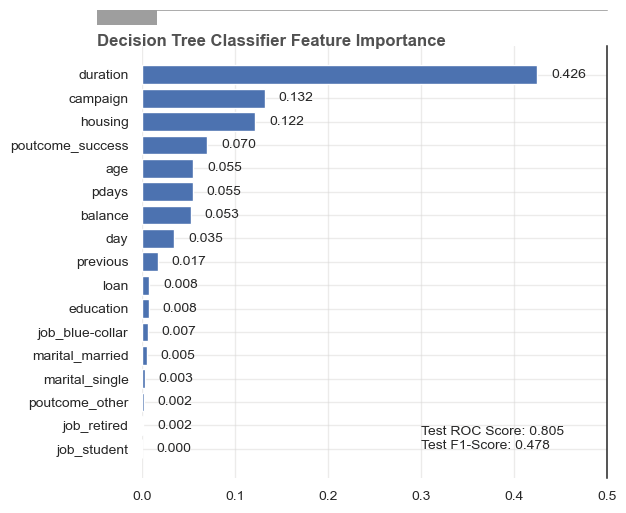

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
graph = ax.barh(dt_importance['Features'], dt_importance['Coeff'])

# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="Decision Tree Classifier Feature Importance", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)

plt.annotate(('Test ROC Score: ' + str(round(dt_cv_auc,3)) + '\nTest F1-Score: ' + str(round(dt_cv_f1,3))),
             xy=(0.3,16), fontsize = 10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.3f', padding =10, fontsize = 10)
ax.set_xlim(right=0.5) 
ax.invert_yaxis()
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.92, wspace=None, hspace=None)

plt.show()


#### Plot Model AUC scores

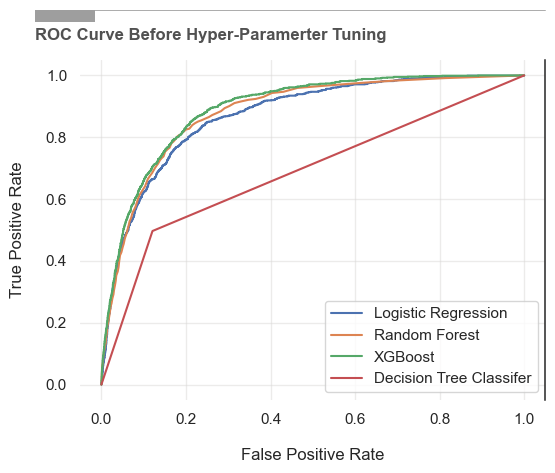

In [46]:
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(lr_over_fpr, lr_over_tpr, label = 'Logistic Regression')
plt.plot(rf_over_fpr, rf_over_tpr, label = 'Random Forest')
plt.plot(xgb_over_fpr, xgb_over_tpr, label = 'XGBoost' )
plt.plot(dt_over_fpr, dt_over_tpr, label ='Decision Tree Classifer')


# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="ROC Curve Before Hyper-Paramerter Tuning", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)


#plt.title('ROC Curve before Hyper-Paramerter Tuning')
plt.xlabel('False Positive Rate', labelpad=15)
plt.ylabel('True Positive Rate', labelpad=15)
plt.legend(facecolor = 'white')
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.88, wspace=None, hspace=None)

plt.show()

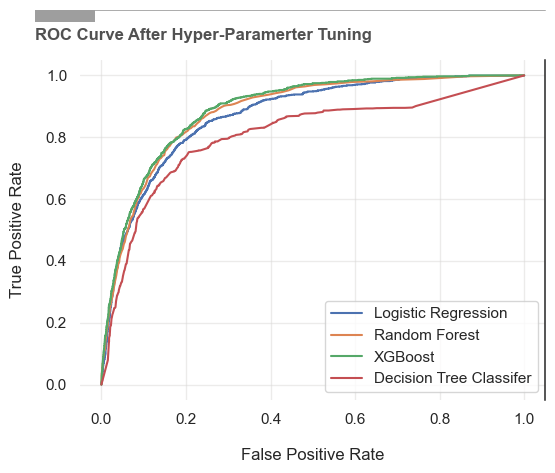

In [47]:
fig, ax = plt.subplots(figsize=(6,5))

plt.plot(lr_cv_fpr, lr_cv_tpr, label = 'Logistic Regression')
plt.plot(rf_cv_fpr, rf_cv_tpr, label = 'Random Forest')
plt.plot(xgb_cv_fpr, xgb_cv_tpr, label = 'XGBoost' )
plt.plot(dt_cv_fpr, dt_cv_tpr, label ='Decision Tree Classifer')

# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="ROC Curve After Hyper-Paramerter Tuning", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)


plt.xlabel('False Positive Rate', labelpad=15)
plt.ylabel('True Positive Rate', labelpad=15)
plt.legend(facecolor = 'white')
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.88, wspace=None, hspace=None)

plt.show()

### Precison-Recall Curve

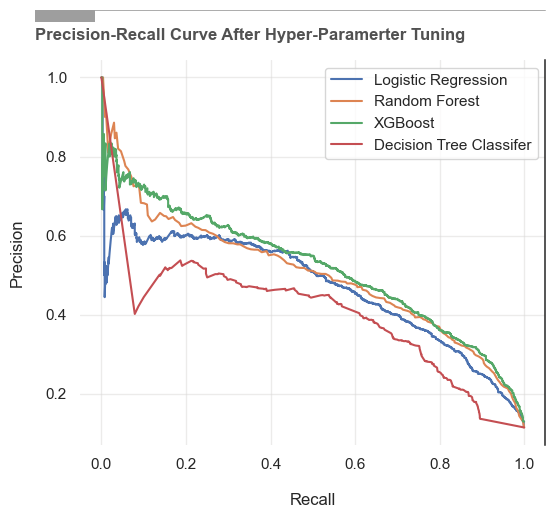

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(lr_cv_recall, lr_cv_precision, label = 'Logistic Regression')
plt.plot(rf_cv_recall, rf_cv_precision, label = 'Random Forest')
plt.plot(xgb_cv_recall, xgb_cv_precision, label = 'XGBoost' )
plt.plot(dt_cv_recall, dt_cv_precision, label ='Decision Tree Classifer')


# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="Precision-Recall Curve After Hyper-Paramerter Tuning", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
#ax.text(x=0.05, y=.9, s="Feature Importance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)

plt.xlabel('Recall', labelpad=15)
plt.ylabel('Precision', labelpad=15)
plt.legend(facecolor = 'white')

plt.show()

In [49]:
def precision_recall(model):
    
    model.fit(X_train_over, y_train_over)
    pred_prob = model.predict_proba(X_test)
    pred_prob = pred_prob[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)

    # Calculate f1 score
    fscore = (2 * precision * recall) / (precision + recall)

    # Find highest f1 score
    f1_score = metrics.f1_score(y_test, model.predict(X_test))
    f1_index = np.argmax(fscore)
    best_threshold = thresholds[f1_index]
    highest_f1_score = fscore[f1_index]
    
    
    # Find ROC score at threshold with highest f1 score
    roc_score = roc_auc_score(y_test, pred_prob)
    idx = (np.abs(thresholds - best_threshold)).argmin()
    roc_score_at_threshold = roc_auc_score(y_test, pred_prob >= thresholds[idx])
    
    
    # Find threshold where precision = recall
    equal_threshold_idx = []
    for pos, value in enumerate(recall):
        if value == precision[pos]:
            equal_threshold_idx.append(pos)
            
    equal_threshold = thresholds[equal_threshold_idx]
    equal_f1_score = fscore[equal_threshold_idx]
    
    
    # Find ROC score at threshold where precision = recall
    idx = (np.abs(thresholds - equal_threshold)).argmin()
    roc_score_at_equal_threshold = roc_auc_score(y_test, pred_prob >= thresholds[equal_threshold_idx])


    print('*********** At Threshold with highest F1 Score ***********')
    print('Threshold = {:.5}'.format(best_threshold))
    print('f1 score =  {:.5}'.format(highest_f1_score))
    print('AUC score = {:.5}'.format(roc_score_at_threshold))
    
    print('\n')
    
    print('*********** At Threshold where Precision = Recall ***********')
    print('Threshold = {:.5}'.format(equal_threshold[0]))
    print('f1 score =  {:.5}'.format(equal_f1_score[0]))
    print('AUC score = {:.5}'.format(roc_score_at_equal_threshold))
    
    print('\n')
    
    print('*********** At Default Threshold ***********')
    print('f1 score =  {:.5}'.format(f1_score))
    print('AUC score = {:.5}'.format(roc_score))
    
    
    
    return(precision, recall, thresholds, best_threshold, equal_threshold)
    

In [50]:
print('Default model before Hyperparamter tuning \n')
def_precision, def_recall, def_thresholds, def_best_threshold, def_equal_threshold =  precision_recall(xgb_over)

Default model before Hyperparamter tuning 

*********** At Threshold with highest F1 Score ***********
Threshold = 0.34199
f1 score =  0.5453
AUC score = 0.77127


*********** At Threshold where Precision = Recall ***********
Threshold = 0.45581
f1 score =  0.53609
AUC score = 0.73794


*********** At Default Threshold ***********
f1 score =  0.51753
AUC score = 0.89265


In [51]:
print('Model After Hyperparamter tuning \n')
cv_precision, cv_recall, cv_thresholds, cv_best_threshold, cv_equal_threshold = precision_recall(xgb_cv)

Model After Hyperparamter tuning 

*********** At Threshold with highest F1 Score ***********
Threshold = 0.38978
f1 score =  0.54517
AUC score = 0.78224


*********** At Threshold where Precision = Recall ***********
Threshold = 0.53922
f1 score =  0.52839
AUC score = 0.73359


*********** At Default Threshold ***********
f1 score =  0.53522
AUC score = 0.89173


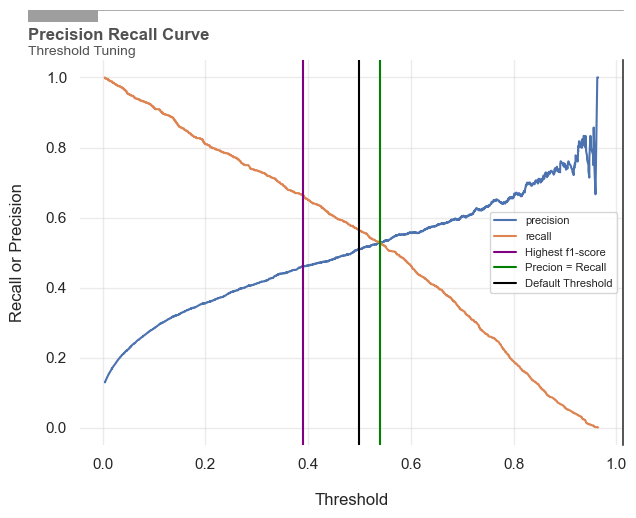

In [61]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(cv_thresholds, cv_precision[:-1], label ='precision')
plt.plot(cv_thresholds, cv_recall[:-1], label ='recall')
plt.axvline(x = cv_best_threshold,
           color = 'purple',
           label = 'Highest f1-score')
plt.axvline(x = cv_equal_threshold,
           color = 'green',
           label = 'Precion = Recall')
plt.axvline(x = 0.5,
           color = 'black',
           label = 'Default Threshold')

# Grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)


# Remove the spines
ax.spines[['top','left','bottom']].set_visible(False)

# Make the left spine thicker
ax.spines['right'].set_linewidth(1.1)

# Add in grey line and rectangle on top
ax.plot([0.05, 0.9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#9E9E9E', linewidth=.6)
ax.add_patch(plt.Rectangle((0.05,.98), 0.1, -0.025, facecolor='#9E9E9E', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add title
ax.text(x=0.05, y=.92, s="Precision Recall Curve", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
ax.text(x=0.05, y=.89, s="Threshold Tuning", transform=fig.transFigure, ha='left', fontsize=10, alpha=.8)

plt.legend(facecolor = 'white', fontsize =8)
#ax.set_ylim(top=1.3) 
plt.ylabel('Recall or Precision', labelpad=15)
plt.xlabel('Threshold', labelpad=15)

plt.show()